<h1>Stanford RNA 3D Folding - Kaggle Competition (March 2025)</h1>
- A transformer based approach  -


## Table of Contents
1. [About the Competition](#about-the-competition)
2. [Motivation](#motivation)
3. [Prerequisites](#prerequisites)
4. [Understanding the Data](#understanding-the-data)
   - [Load the Data](#load-the-data)
   - [3D Visualization](#3d-visualization)
5. [Exploratory Data Analysis](#exploratory-data-analysis)
   - [Overview](#overview)
   - [Sequence Length](#sequence-length)
   - [Missing Values](#missing-values)
   - [Coordinates](#coordinates)
   - [Findings of Initial EDA](#findings-of-initial-eda)
6. [Baseline Model](#baseline-model)
   - [Data Preprocessing](#data-preprocessing)
   - [Create Dataset and Dataloaders](#create-dataset-and-dataloaders)
   - [Loss Function](#loss-function)
   - [Create a Simple Baseline Model](#create-a-simple-baseline-model)
   - [Training](#training)
   - [First Submission](#first-submission)
   - [Another Simple Model](#another-simple-model)
7. [Get Data for Pre-training](#get-data-for-pre-training)
   - [Parse the Protein Database Files](#parse-the-protein-database-files)
   - [Mini EDA](#mini-eda)
   - [Preprocessing](#preprocessing)
8. [RNA Transformer V1](#rna-transformer-v1)
   - [Pretraining](#pretraining)
   - [Finetune](#finetune)
9. [RNA Transformer V2](#rna-transformer-v2)
   - [Pretraining](#pretraining-1)
   - [Finetune](#finetune)
10. [Conclusion](#conclusion)

## About the competition

"RNA is vital to life’s most essential processes, but despite its significance, predicting its 3D structure is still difficult. Deep learning breakthroughs like AlphaFold have transformed protein structure prediction, but progress with RNA has been much slower due to limited data and evaluation methods.

This competition builds on recent advances, like the deep learning foundation model RibonanzaNet, which emerged from a prior Kaggle competition. Now, you’ll take on the next challenge—predicting RNA’s full 3D structure.

Your work could push RNA-based medicine forward, making treatments like cancer immunotherapies and CRISPR gene editing more accessible and effective. More fundamentally, your work may be the key step in illuminating the folds and functions of natural RNA molecules, which have been called the 'dark matter of biology'.

This competition is made possible through a worldwide collaborative effort including the organizers, experimental RNA structural biologists, and predictors of the CASP16 and RNA-Puzzles competitions; Howard Hughes Medical Institute; the Institute of Protein Design; and Stanford University School of Medicine."

<small>[Shujun He, CASP16 organizers, CASP16 RNA experimentalists, RNA-Puzzles consortium, VFOLD team, Rachael Kretsch, Alissa Hummer, Andrew Favor, Walter Reade, Maggie Demkin, Rhiju Das, et al. Stanford RNA 3D Folding. https://kaggle.com/competitions/stanford-rna-3d-folding, 2025. Kaggle.]</small>

## Motivation

This notebook is dedicated to forecasting the spatial coordinates of ribonucleic acid (RNA) given a sequence of nucleotides (primary structure). This problem is defined as a sequence-to-sequence problem and has proven to be a good use case of attention-based architectures. The goal is to get an in-depth knowledge of the transformer architecture, which was introduced in the paper [Attention is all you need](https://arxiv.org/abs/1706.03762).

On a quest to become more knowledgeable in the field of Deep Learning and AI, this will be a good opportunity to get hands-on experience with state-of-the-art deep learning architectures.

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_column", 999)
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import DataLoader, Dataset
from torch import Tensor,nn
from fastai.vision.all import accuracy, Learner, Adam , DataLoaders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from torch.optim import Optimizer
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import pickle
import os
from typing import List
import gc
import math
from IPython.display import Image, display


In [134]:
# File paths
TRAIN_SEQ_PATH = '../data/train_sequences.csv'
TRAIN_SEQ2_PATH = '../data/train_sequences.v2.csv'
TRAIN_LABELS_PATH = '../data/train_labels.csv'
TRAIN_LABELS2_PATH = '../data/train_labels.v2.csv'
VALID_SEQ_PATH = '../data/validation_sequences.csv'
VALID_LABELS_PATH = '../data/validation_labels.csv'
TEST_SEQ_PATH  = '../data/test_sequences.csv'
SAMPLE_SUB_PATH = '../data/sample_submission.csv'
SUBMISSION_PATH = '../submissions/submission.csv'
PICKLE_FOLDER_SEQUENCES = "../data/pickle/sequences"
PICKLE_FOLDER_TARGETS = "../data/pickle/targets"
PICKLE_FOLDER_BATCHES = "../data/pickle/batches"
PICKLE_DIR="../data/synthetic_data/pickle/preprocessed"
PICKLE_DIR_BASE = "../data/synthetic_data/pickle"
MODEL_DIR = "../models"
DATASET_DIR = "../data"
PRETRAIN_DATASET_DIR = "../data/archive/compile_all"

# Config
PDB_PROCESSING_ENABLED = False      # if True, the PDB files will be processed and saved to pickle files (you only need to do this once)
BASELINE_TRAINING_ENABLED = False   # if True, the baseline models will be trained (will not increasee runtime substantially)
V1_FINETUNE_ENABLED = False         # if True, the RNATransformer v1 model finetune is enabled (takes a long time)
V1_PRETRAIN_ENABLED = False         # if True, the RNATransformer v1 model pretrain is enabled (takes a long time)
V2_FINETUNE_ENABLED = False         # if True, the RNATransformer v2 model finetune is enabled (takes a long time)
V2_PRETRAIN_ENABLED = False         # if True, the RNATransformer v2 model pretrain is enabled (takes a long time)
RECREATE_PLOTS = False              # if True, compute intense plots will be re-created (increases runtime of notebook)
INTERACTIVE_PLOTS = False           # if True, interactive plots will be created (does not work in github preview), if set to False, static plots will be shown 
DEVICE = "cpu"                      # "cuda" if cuda GPU is available, else "cpu"

## Understanding the data

### Load the data

In [3]:
train_sequences = pd.read_csv(TRAIN_SEQ_PATH)
train_sequences2 = pd.read_csv(TRAIN_SEQ2_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)
train_labels2 = pd.read_csv(TRAIN_LABELS2_PATH)
valid_sequences = pd.read_csv(VALID_SEQ_PATH)
valid_labels = pd.read_csv(VALID_LABELS_PATH)
test_sequences = pd.read_csv(TEST_SEQ_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

print("Train Sequences Shape:", train_sequences.shape)
print("Train Labels Shape:", train_labels.shape)
print("Train Sequences2 Shape:", train_sequences2.shape)
print("Train Labels2 Shape:", train_labels2.shape)
print("Validation Sequences Shape:", valid_sequences.shape)
print("Validation Labels Shape:", valid_labels.shape)
print("Test Sequences Shape:", test_sequences.shape)

Train Sequences Shape: (844, 5)
Train Labels Shape: (137095, 6)
Train Sequences2 Shape: (5135, 5)
Train Labels2 Shape: (3677095, 6)
Validation Sequences Shape: (12, 5)
Validation Labels Shape: (2515, 123)
Test Sequences Shape: (12, 5)


In [4]:
valid_sequences.head()

,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ribozyme,>7QR4_1|Chain A|U1 small nuclear ribonucleoprotein A|Homo sapiens (9606)\nRPNHTIYINNLNEKIKKDELKKSLHAIFSRFGQILDILVSRSLKMRGQAFVIFKEVSSATNALRSMQGFPFYDKPMRIQYAKTDSDIIAKM\n>7QR4_2|Chain B|RNA CPEB3 ribozyme|Homo sapiens (9606)\nGGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 HDV-like ribozyme,">7QR3_1|Chains A, B|U1 small nuclear ribonucleoprotein A|Homo sapiens (9606)\nRPNHTIYINNLNEKIKKDELKKSLHAIFSRFGQILDILVSRSLKMRGQAFVIFKEVSSATNALRSMQGFPFYDKPMRIQYAKTDSDIIAKM\n>7QR3_2|Chains C, D|chimpanzee CPEB3 ribozyme|Pan troglodytes (9598)\nGGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU"
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGGGGUUGUACCCACCCCAGAGGCCCACGUGGCGGCUAGUACUCCGGUAUUGCGGUACCCUUGUACGCCUGUUUUAGCCGCGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCA,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure of Poliovirus (type 1 Mahoney) cloverleaf RNA with tRNA scaffold,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,Poliovirus cloverleaf RNA|Homo sapiens (9606)\nCGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGGGGUUGUACCCACCCCAGAGGCCCACGUGGCGGCUAGUACUCCGGUAUUGCGGUACCCUUGUACGCCUGUUUUAGCCGCGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCA"
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoniae\nAdditional Information: This is a ligand-only target (re-release of R1117 with the corrected SMILES string).\nID Name SMILES Relevant\n001 PRF NCc1c[nH]c2nc(N)[nH]c(=O)c12 Yes\nClass I type III preQ1 riboswitch from E. coli,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|Escherichia coli (562)\nUUGGGUUCCCUCACCCCAAUCAUAAAAAGG"
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUUACACCAUGCAACGCAGACCUGUAGAUGCCACGCUAGCCGUGGUGAGGGUCGGGUCCAGAUGUCAUUCGACUUUAACGCGCCUAAGCGUUGAAGGCGUGUUAGAGCAGAUAGUUCGCUAUCUGGGGAGCCUGUUCGCAGGCUCAGGAGCCUUCGGGCUCCUAGCGCUAUUACCCCGGACACCACCGGGCAGACAAGUAAUGGUGCUCCUCGAAUGACUUCUGUUGAGUAGAGUGUGGGCUCCGCGGCUAGUGUGCACCUUAGCGGUGAAUGUCUGACACCGUUAAGGUGGUUACUCUUCGGAGUAACGCCGAGAUUCC,2022-06-11,Traptamer\nSynthetic\nAdditional Information: Contains a relevant ion.\nRNA origami 3-helix tile Traptamer,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|synthetic construct (32630)\nGGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUUACACCAUGCAACGCAGACCUGUAGAUGCCACGCUAGCCGUGGUGAGGGUCGGGUCCAGAUGUCAUUCGACUUUAACGCGCCUAAGCGUUGAAGGCGUGUUAGAGCAGAUAGUUCGCUAUCUGGGGAGCCUGUUCGCAGGCUCAGGAGCCUUCGGGCUCCUAGCGCUAUUACCCCGGACACCACCGGGCAGACAAGUAAUGGUGCUCCUCGAAUGACUUCUGUUGAGUAGAGUGUGGGCUCCGCGGCUAGUGUGCACCUUAGCGGUGAAUGUCUGACACCGUUAAGGUGGUUACUCUUCGGAGUAACGCCGAGAUUCC


In [5]:
test_sequences.head()

,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ribozyme,>7QR4_1|Chain A|U1 small nuclear ribonucleoprotein A|Homo sapiens (9606)\nRPNHTIYINNLNEKIKKDELKKSLHAIFSRFGQILDILVSRSLKMRGQAFVIFKEVSSATNALRSMQGFPFYDKPMRIQYAKTDSDIIAKM\n>7QR4_2|Chain B|RNA CPEB3 ribozyme|Homo sapiens (9606)\nGGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 HDV-like ribozyme,">7QR3_1|Chains A, B|U1 small nuclear ribonucleoprotein A|Homo sapiens (9606)\nRPNHTIYINNLNEKIKKDELKKSLHAIFSRFGQILDILVSRSLKMRGQAFVIFKEVSSATNALRSMQGFPFYDKPMRIQYAKTDSDIIAKM\n>7QR3_2|Chains C, D|chimpanzee CPEB3 ribozyme|Pan troglodytes (9598)\nGGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU"
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGGGGUUGUACCCACCCCAGAGGCCCACGUGGCGGCUAGUACUCCGGUAUUGCGGUACCCUUGUACGCCUGUUUUAGCCGCGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCA,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure of Poliovirus (type 1 Mahoney) cloverleaf RNA with tRNA scaffold,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,Poliovirus cloverleaf RNA|Homo sapiens (9606)\nCGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGGGGUUGUACCCACCCCAGAGGCCCACGUGGCGGCUAGUACUCCGGUAUUGCGGUACCCUUGUACGCCUGUUUUAGCCGCGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCA"
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoniae\nAdditional Information: This is a ligand-only target (re-release of R1117 with the corrected SMILES string).\nID Name SMILES Relevant\n001 PRF NCc1c[nH]c2nc(N)[nH]c(=O)c12 Yes\nClass I type III preQ1 riboswitch from E. coli,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|Escherichia coli (562)\nUUGGGUUCCCUCACCCCAAUCAUAAAAAGG"
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUUACACCAUGCAACGCAGACCUGUAGAUGCCACGCUAGCCGUGGUGAGGGUCGGGUCCAGAUGUCAUUCGACUUUAACGCGCCUAAGCGUUGAAGGCGUGUUAGAGCAGAUAGUUCGCUAUCUGGGGAGCCUGUUCGCAGGCUCAGGAGCCUUCGGGCUCCUAGCGCUAUUACCCCGGACACCACCGGGCAGACAAGUAAUGGUGCUCCUCGAAUGACUUCUGUUGAGUAGAGUGUGGGCUCCGCGGCUAGUGUGCACCUUAGCGGUGAAUGUCUGACACCGUUAAGGUGGUUACUCUUCGGAGUAACGCCGAGAUUCC,2022-06-11,Traptamer\nSynthetic\nAdditional Information: Contains a relevant ion.\nRNA origami 3-helix tile Traptamer,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|synthetic construct (32630)\nGGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUUACACCAUGCAACGCAGACCUGUAGAUGCCACGCUAGCCGUGGUGAGGGUCGGGUCCAGAUGUCAUUCGACUUUAACGCGCCUAAGCGUUGAAGGCGUGUUAGAGCAGAUAGUUCGCUAUCUGGGGAGCCUGUUCGCAGGCUCAGGAGCCUUCGGGCUCCUAGCGCUAUUACCCCGGACACCACCGGGCAGACAAGUAAUGGUGCUCCUCGAAUGACUUCUGUUGAGUAGAGUGUGGGCUCCGCGGCUAGUGUGCACCUUAGCGGUGAAUGUCUGACACCGUUAAGGUGGUUACUCUUCGGAGUAACGCCGAGAUUCC


In [6]:
train_sequences = pd.concat([train_sequences, train_sequences2], axis=0, ignore_index=True)
train_labels = pd.concat([train_labels, train_labels2], axis=0, ignore_index=True)
print("Combined Train Sequences Shape:", train_sequences.shape)
print("Combined Train Labels Shape:", train_labels.shape)

Combined Train Sequences Shape: (5979, 5)
Combined Train Labels Shape: (3814190, 6)


In [7]:
train_sequences = train_sequences.drop_duplicates(subset=None, keep='first')
train_labels = train_labels.drop_duplicates(subset=None, keep='first')

print(train_sequences.shape)
print(train_labels.shape)

(5448, 5)
(3723759, 6)


>We have 5448 experimentally verified RNA sequences.

>The sequences have an unique ID (target_id), the sequence described by their residues, and some additionaly information that is not of interest for now

In [8]:
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


> The labels consist of the 3 dimensial coordinates, x,y,z for each residue of each sequence. The mapping of coordinates to sequence residue is made by the ID column. For example the ID 1SCL_A_2 refers to the second residue of the sequence 1SCL_A:

G<b><u>G</u></b>GUGCUCAGUACGAGAGGAACCGCACCC

> That means, the position in 3 dimensional Coordinates (Angstrom Coordinates) of the second residues (<b>G</b>) atom is x=9.310,y=-29.638000,z=2.669


<b>Lets visualize this 3D structure</b>


### 3D visualization

In [9]:
# enrich the train_labels and valid_labels with a column for the sequence name
train_labels["sequence_id"] = train_labels["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))
valid_labels["sequence_id"] = valid_labels["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1,sequence_id
0,1SCL_A_1,G,1,13.760,-25.974001,0.102,1SCL_A
1,1SCL_A_2,G,2,9.310,-29.638000,2.669,1SCL_A
2,1SCL_A_3,G,3,5.529,-27.813000,5.878,1SCL_A
3,1SCL_A_4,U,4,2.678,-24.900999,9.793,1SCL_A
4,1SCL_A_5,G,5,1.827,-20.136000,11.793,1SCL_A


In [10]:
def plot_structure(df: pd.DataFrame, sequence_id: str) -> None:
    sequence_df = df[df["sequence_id"] == sequence_id]
    sequence_points = sequence_df[["x_1", "y_1", "z_1", "resname"]]
    
    colors = {"A": "red", "G": "blue", "C": "green", "U": "orange"}
    fig = go.Figure()
    
    for resname, color in colors.items():
        subset = sequence_df[sequence_df["resname"] == resname]
        fig.add_trace(go.Scatter3d(
            x=subset["x_1"], y=subset["y_1"], z=subset["z_1"],
            mode='markers',
            marker=dict(size=5, color=color),
            name=resname,
        ))
    
    fig.add_trace(go.Scatter3d(
        x=sequence_df["x_1"], y=sequence_df["y_1"], z=sequence_df["z_1"],
        mode='lines',
        line=dict(color='gray', width=2),
        name='RNA Backbone'
    ))
    
    fig.update_layout(
            scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
            title=f'3D RNA Structure of sequence {sequence_id}',
        )
            
    fig.show()

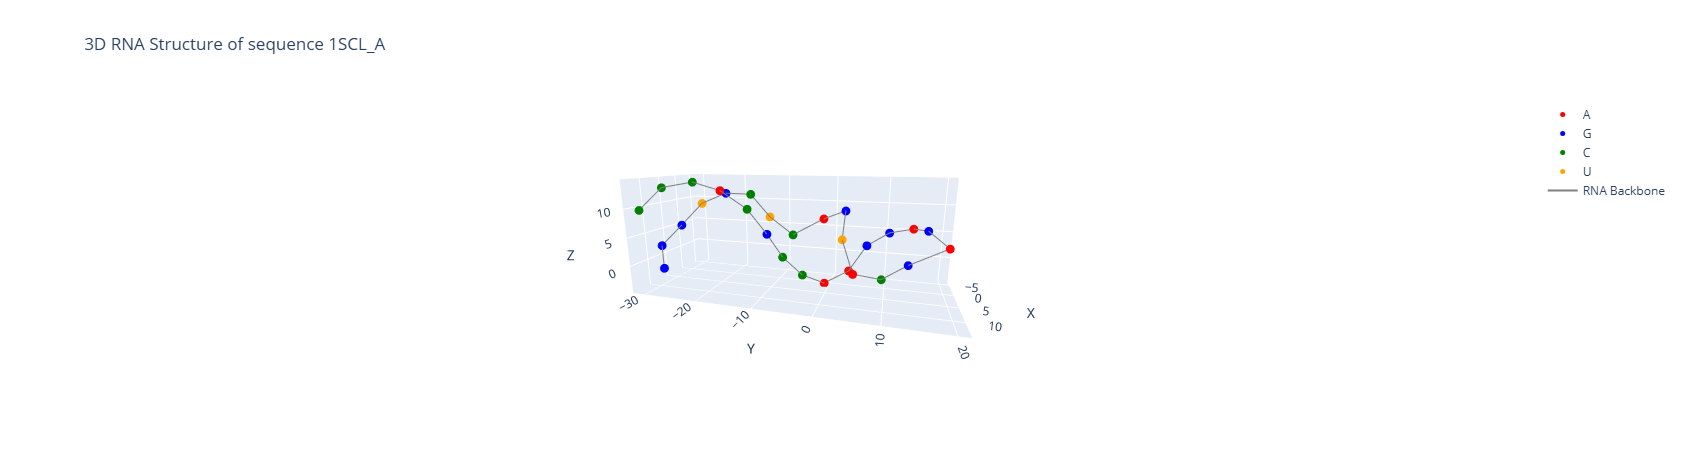

In [138]:
if INTERACTIVE_PLOTS:
    plot_structure(train_labels, "1SCL_A")
else:
    display(Image("images/1SCL_A.png"))  

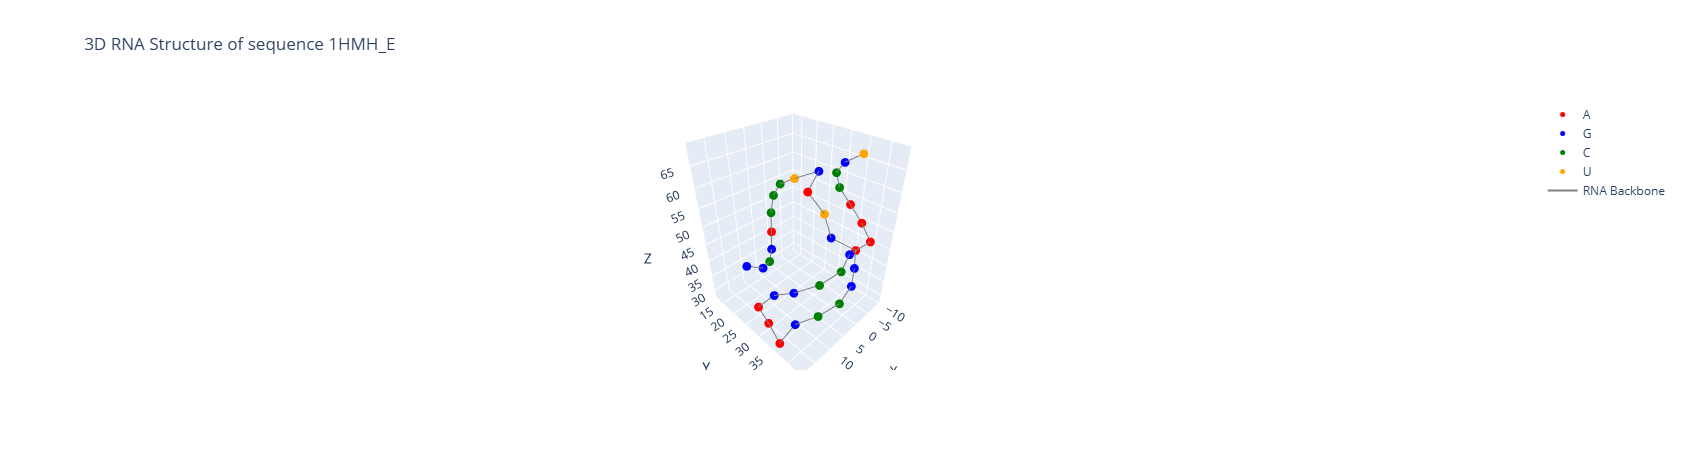

In [139]:
if INTERACTIVE_PLOTS:
    plot_structure(train_labels, "1HMH_E")
else: 
    display(Image("images/1HMH_E.png"))

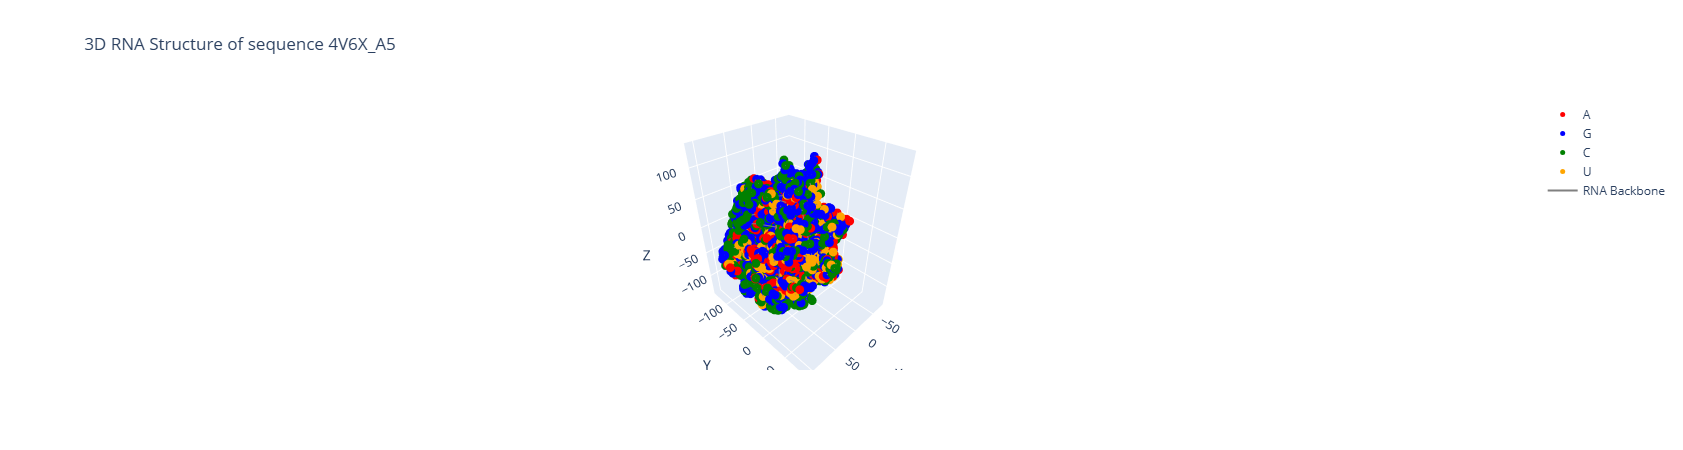

In [140]:
if INTERACTIVE_PLOTS:
    plot_structure(train_labels, "4V6X_A5")
else:
    display(Image("images/4V6X_A5.png"))

>Now as we have a feeling for what those RNA sequences can look like, lets gain some more insights on the complete dataset

## Exploratory Data Analysis

### Overview

In [14]:
train_labels.describe()

,resid,x_1,y_1,z_1
count,3.723759e+06,3.682297e+06,3.682297e+06,3.682297e+06
mean,1.136592e+03,1.676737e+02,1.707516e+02,1.677687e+02
std,8.753811e+02,1.251037e+02,1.223373e+02,1.268565e+02
min,1.000000e+00,-9.420170e+02,-7.994280e+02,-4.659170e+02
25%,3.850000e+02,1.055750e+02,1.130510e+02,1.078590e+02
50%,9.870000e+02,1.940310e+02,1.935820e+02,1.893010e+02
75%,1.721000e+03,2.479720e+02,2.498700e+02,2.467840e+02
max,4.417000e+03,8.498870e+02,8.895080e+02,1.160219e+03


>longest sequence is 4417 residues long

In [15]:
valid_labels.describe()

,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,x_6,y_6,z_6,x_7,y_7,z_7,x_8,y_8,z_8,x_9,y_9,z_9,x_10,y_10,z_10,x_11,y_11,z_11,x_12,y_12,z_12,x_13,y_13,z_13,x_14,y_14,z_14,x_15,y_15,z_15,x_16,y_16,z_16,x_17,y_17,z_17,x_18,y_18,z_18,x_19,y_19,z_19,x_20,y_20,z_20,x_21,y_21,z_21,x_22,y_22,z_22,x_23,y_23,z_23,x_24,y_24,z_24,x_25,y_25,z_25,x_26,y_26,z_26,x_27,y_27,z_27,x_28,y_28,z_28,x_29,y_29,z_29,x_30,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32,x_33,y_33,z_33,x_34,y_34,z_34,x_35,y_35,z_35,x_36,y_36,z_36,x_37,y_37,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
count,2515.000000,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03,2.515000e+03
mean,188.016700,-5.964215e+15,-5.964215e+15,-5.964215e+15,-5.717694e+17,-5.717694e+17,-5.717694e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-8.970179e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17,-9.463221e+17
std,176.059971,7.701299e+16,7.701299e+16,7.701299e+16,4.949208e+17,4.949208e+17,4.949208e+17,3.039960e+17,3.039960e+17,3.039960e+17,3.039960e+17,3

> longest sequence in validation set is 720 residues

> Validation set has 40 3d structures for each sequence

> There seem to be invalid coordinates in the validation set (min value is -1e+18)

### Sequence length

In [16]:
train_labels.sequence_id.value_counts().mean()

np.float64(692.2771890686001)

In [17]:
valid_labels.sequence_id.value_counts().mean()

np.float64(209.58333333333334)

> The training sequences are on average longer

> Let's take a look at the distribution of sequence length

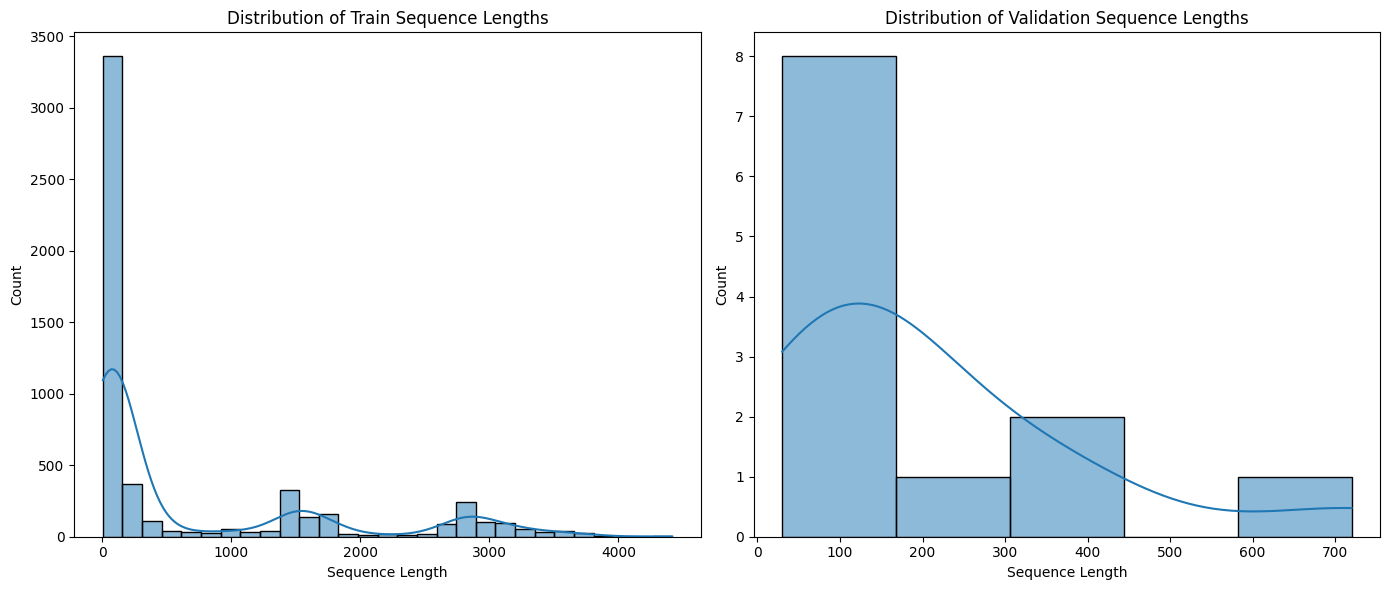

In [18]:
train_sequences['seq_length'] = train_sequences['sequence'].apply(len)
valid_sequences['seq_length'] = valid_sequences['sequence'].apply(len)
test_sequences['seq_length'] = test_sequences['sequence'].apply(len)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_sequences['seq_length'], kde=True)
plt.title('Distribution of Train Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(valid_sequences['seq_length'], kde=True)
plt.title('Distribution of Validation Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [19]:
train_sequences['seq_length'].describe()

count    5448.000000
mean      690.713289
std      1046.686059
min         3.000000
25%        47.000000
50%        94.000000
75%      1415.750000
max      4417.000000
Name: seq_length, dtype: float64

In [20]:
valid_sequences['seq_length'].describe()

count     12.000000
mean     209.583333
std      194.493963
min       30.000000
25%      105.750000
50%      129.500000
75%      269.250000
max      720.000000
Name: seq_length, dtype: float64

In [21]:
test_sequences['seq_length'].describe()

count     12.000000
mean     209.583333
std      194.493963
min       30.000000
25%      105.750000
50%      129.500000
75%      269.250000
max      720.000000
Name: seq_length, dtype: float64

Lets have a look at the distribution of nucleotide residues

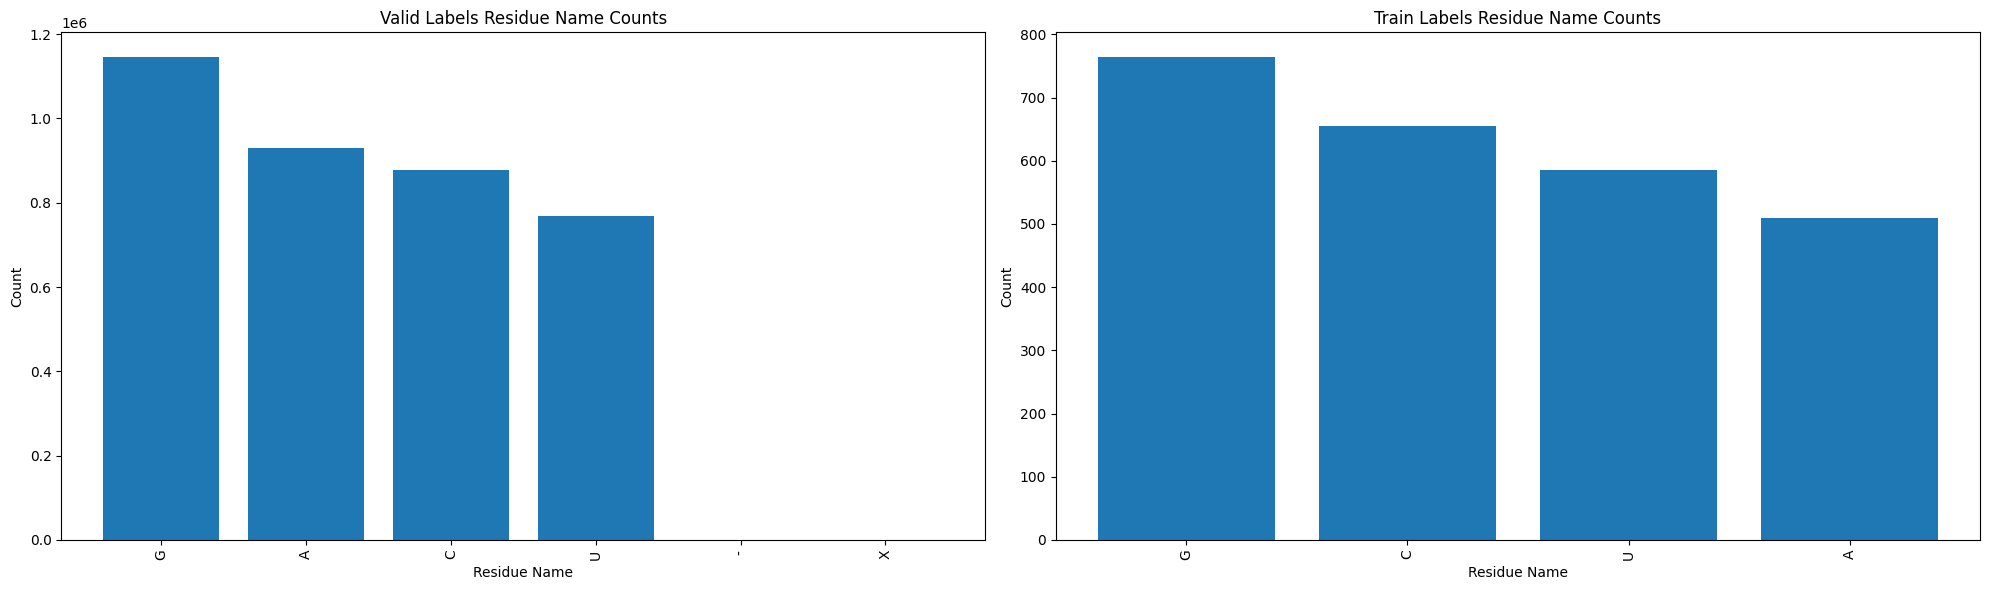

In [22]:
import matplotlib.pyplot as plt

valid_counts = valid_labels.resname.value_counts()
train_counts = train_labels.resname.value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].bar(train_counts.index, train_counts.values)
axs[0].set_title('Valid Labels Residue Name Counts')
axs[0].set_xlabel('Residue Name')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=90)

axs[1].bar(valid_counts.index, valid_counts.values)
axs[1].set_title('Train Labels Residue Name Counts')
axs[1].set_xlabel('Residue Name')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=90)

fig.tight_layout()

plt.show()

> The most common residue is G. All in all the distribution of residues is relatively balanced 

> Also we have some entries that seem to be faulty (resname is - or X). Let's identify the sequences:

### Missing values

In [23]:
train_labels[train_labels.resname.isin(['X', '-'])]

,ID,resname,resid,x_1,y_1,z_1,sequence_id
87426,6WB1_C_53,-,53,146.863998,162.598007,114.521004,6WB1_C
87427,6WB1_C_54,-,54,148.063995,168.145004,113.511002,6WB1_C
94043,6Y0C_IN1_15,-,15,255.529999,194.612000,232.932999,6Y0C_IN1
94044,6Y0C_IN1_16,-,16,254.729996,200.151001,233.839005,6Y0C_IN1
113186,7SLP_R_1,X,1,NaN,NaN,NaN,7SLP_R
...,...,...,...,...,...,...,...
3635921,2GBH_A_1,X,1,NaN,NaN,NaN,2GBH_A
3655223,5D0B_F_8,X,8,NaN,NaN,NaN,5D0B_F
3729468,4C8Z_C_28,X,28,NaN,NaN,NaN,4C8Z_C
3747826,8Y6O_J_1,X,1,NaN,NaN,NaN,8Y6O_J


>750 cases with invalid resname entries. We handle them right away

>We replace the - and X resnames with the most common residue "G":

In [24]:
train_labels.loc[train_labels.resname == '-', 'resname'] = train_labels.loc[train_labels.resname == '-', 'resname'].replace('-', 'G')
train_labels.loc[train_labels.resname == 'X', 'resname'] = train_labels.loc[train_labels.resname == 'X', 'resname'].replace('X', 'G')

> Now we do the same for the train_sequences

In [25]:
pattern = re.compile(r'[^GCAU]')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x)))]

,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length
610,6WB1_C,GACUCUGGUAACUAGAGAUCCCUCAGACCCUUUUAGUCAGUGUGGAAAAUCU--CUAGCAGUGGCGCCCGAACAGGGACUUGAAAGCGAAAGUAAAGCCAGAG,2020-06-24,+3 extended HIV-1 reverse transcriptase initiation complex core (intermediate state),>6WB1_1|Chain A[auth C]|HIV-1 viral RNA genome fragment|Human immunodeficiency virus 1 (11676)\nGACUCUGGUAACUAGAGAUCCCUCAGACCCUUUUAGUCAGUGUGGAAAAUCUCUAGCAGUGGCGCCCGAACAGGGACUUGAAAGCGAAAGUAAAGCCAGAG\n>6WB1_2|Chain B[auth D]|tRNA lysine 3|Homo sapiens (9606)\nGCCCGGAUAGCUCAGUCGGUAGAGCAUCAGACUUUUAAUCUGAGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCACTG\n>6WB1_3|Chain C[auth A]|REVERSE TRANSCRIPTASE/RIBONUCLEASE H|Human immunodeficiency virus type 1 group M subtype B (isolate BH10) (11678)\nMVPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYF...,103
639,6Y0C_IN1,AGUAGAAACAAGGG--UAUUUUUCUUUACUAGUCUACCCUGCUUUUGCU,2020-11-25,Influenza C virus polymerase in complex with human ANP32A - Subclass 2,>6Y0C_1|Chain A|Polymerase acidic protein|Influenza C virus (C/Johannesburg/1/66) (100673)\nMSKTFAEIAEAFLEPEAVRIAKEAVEEYGDHERKIIQIGIHFQVCCMFCDEYLSTNGSDRFVLIEGRKRGTAVSLQNELCKSYDLEPLPFLCDIFDREEKQFVEIGITRKADDSYFQSKFGKLGNSCKIFVFSYDGRLDKNCEGPMEEQKLRIFSFLATAADFLRKENMFNEIFLPDNEETIIEMKKGKTFLELRDESVPLPFQTYEQMKDYCEKFKGNPRELASKVSQMQSNIKLPIKHYEQNKFRQIRLPKGPMAPYTHKFLMEEAWMFTKISDPERSRAGEILIDFFKKGNLSAIRPKDKPLQGKYPIHYKNLWNQIKAAIADRTMVINENDHSEFLGGIGRASKKIPEISLTQDVITTEGLKQSENKLPEPRSFPRWFNAEWMWAIKDSDLTGWVPMAEYPPADNELEDYAEHLNKTMEGVLQGTNCAREMGKCILTVGALMTECRLFPGKIKVVPIYARSKERKSMQEGLPVPSEMDCLFGICVKSKSHLNKDDGMYTI...,49
687,7SLP_R,XGAUGUGAGGGCGACUUCGGUCCUCCCUCACCGCUCCAUGUGCGAAAUGAGGCGCUGCAUGUGGCAGUCUGCCUUUCUUUU,2022-03-30,Cryo-EM structure of 7SK core RNP with linear RNA,>7SLP_1|Chain A|7SK snRNA methylphosphate capping enzyme|Homo sapiens (9606)\nMGSSHHHHHHSSGLVPRGSPLPAAGFKKQQRKFQYGNYCKYYGYRNPSCEDGRLRVLKPEWFRGRDVLDLGCNVGHLTLSIACKWGPSRMVGLDIDSRLIHSARQNIRHYLSEELRLPPQTLEGDPGAEGEEGTTTVRKRSCFPASLTASRGPIAAPQVPLDGADTSVFPNNVVFVTGNYVLDRDDLVEAQTPEYDVVLCLSLTKWVHLNWGDEGLKRMFRRIYRHLRPGGILVLEPQPWSSYGKRKTLTETIYKNYYRIQLKPEQFSSYLTSPDVGFSSYELVATPHNTSKGFQRPVYLFHKARSPSH\n>7SLP_2|Chain B|La-related protein 7|Homo sapiens (9606)\nGMETESGNQEKVMEEESTEKKKEVEKKKRSRVKQVLADIAKQVDFWFGDANLHKDRFLREQIEKSRDGYVDISLLVSFNKMKKLTTDGKLIARALRSSAVVELDLEGTRIRRKKPLGERPKDEDERTVYVELLPKNVNHSWIERVFGKC...,81
782,8H6E_4A,XAGCUUUGCGCAGUGGCAGUAUCGUAGCCAAUGAGGUCUAUCCGAGGCGCGAUUAUUGCUAAUUGAAAACUUUUCCCAAUACCCCGCCGUGACGACUUGCAAUAUAGUCGGCACUGGCAAUUUUUGACAGUCUCUACGGAGACUGG,2024-05-01,Cryo-EM structure of human exon-defined spliceosome in the late pre-B state.,>8H6E_1|Chain A|pre-mRNA|Homo sapiens (9606)\nGGGAGGUUUCCUUGAAGCUUUCGUGCUGACCCUGUCCCUUUUUUUUCCACAGGGGCGAAUUCGAGCUCACUCUCUUCCGCAUCGCUGUCUGCGAGGUACCCUACCAGGUGAGUAUGGAUCCCUCUAAAAGCGGGCAUGACUUCU\n>8H6E_3|Chain C[auth 6a]|U6 snRNA-associated Sm-like protein LSm2|Homo sapiens (9606)\nMLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ\n>8H6E_4|Chain D[auth 6b]|U6 snRNA-associated Sm-like protein LSm3|Homo sapiens (9606)\nMADDVDQQQTTNTVEEPLDLIRLSLDERIYVKMRNDRELRGRLHAYDQHLNMILGDVEETVTTIEIDEETYEEIYKSTKRNIPMLFVRGDGVVLVAPPLRVG\n>8H6E_5|Chain E[auth 6c]|U6 s...,146
856,6U7Y_A,XUGCUGGCUAAGGXCCGAAAGG,2020-12-09,RNA hairpin structure containing one TNA nucleotide as template,>6U7Y_1|Chain A|RNA (5'-R(*CP*UP*GP*CP*UP*GP*GP*CP*UP*AP*AP*GP*GP*(TG)P*CP*CP*GP*AP*AP*AP*GP*G)-3')|synthetic construct (32630)\nXUGCUGGCUAAGGXCCGAAAGG\n>6U7Y_2|Chain B|RNA (5'-R(*CP*UP*AP*UP*GP*CP*CP*UP*GP*CP*UP*G)-3')|synthetic construct (32630)\nCUAUGCCUGCUG\n,22
...,...,...,...,...,...,...
5749,2GBH_A,XGGCUAAUGUUGAAAAAUUAGCCC,2006-04-11,NMR structure of stem region of helix-35 of 23S E.coli ribosomal RNA (residues 736-760),>2GBH_1|Chain A|5'-R(*(GMP)P*GP*GP*CP*UP*AP*AP*UP*GP*(PSU)P*UP*GP*AP*AP*AP*AP*AP*UP*UP*AP*GP*CP*CP*C)-3'|null\nXGGCUAAUGUUGAAAAAUUAGCCC\n,24
5769,5D0B_F,GCAGACUXUAAAUCUGC,2016-09-28,Crystal structure of epoxyqueuosin

>We identified the same faulty entries and handle them

In [26]:
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('X', 'G')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('-', 'G')

>Now we check the labels for missing values

In [27]:
train_labels.isna().sum()

ID                 0
resname            0
resid              0
x_1            41462
y_1            41462
z_1            41462
sequence_id        0
dtype: int64

In [28]:
valid_labels.isna().sum()

ID             0
resname        0
resid          0
x_1            0
y_1            0
              ..
z_39           0
x_40           0
y_40           0
z_40           0
sequence_id    0
Length: 124, dtype: int64

In [29]:
train_sequences.isna().sum()

target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      6
seq_length         0
dtype: int64

In [30]:
valid_sequences.isna().sum()

target_id          0
sequence           0
temporal_cutoff    0
description        0
all_sequences      0
seq_length         0
dtype: int64

> Nothing to handle in train_sequences, but there is a substantial amount of missing coordinates in the train labels
> Let's also handle them right away
> We will fill them with the mean value for the respective column

In [31]:
train_labels.fillna({ 'x_1': train_labels['x_1'].mean()}, inplace=True)
train_labels.fillna({ 'y_1': train_labels['y_1'].mean()}, inplace=True)
train_labels.fillna({ 'z_1': train_labels['z_1'].mean()}, inplace=True)
train_labels.isna().sum()

ID             0
resname        0
resid          0
x_1            0
y_1            0
z_1            0
sequence_id    0
dtype: int64

As noticed before some invalid values of -1e+18 are in the validation dataset. We handle them the same way as the missing values

In [32]:
valid_labels = valid_labels.replace(-1e+18, np.nan)
valid_labels.fillna({ 'x_1': valid_labels['x_1'].mean()}, inplace=True)
valid_labels.fillna({ 'y_1': valid_labels['y_1'].mean()}, inplace=True)
valid_labels.fillna({ 'z_1': valid_labels['z_1'].mean()}, inplace=True)
valid_labels.isna().sum()

ID                0
resname           0
resid             0
x_1               0
y_1               0
               ... 
z_39           2380
x_40           2380
y_40           2380
z_40           2380
sequence_id       0
Length: 124, dtype: int64

### Coordinates

> Now we create a pairplot to see how the coordinates are distributed and if there are any correlations noticeable

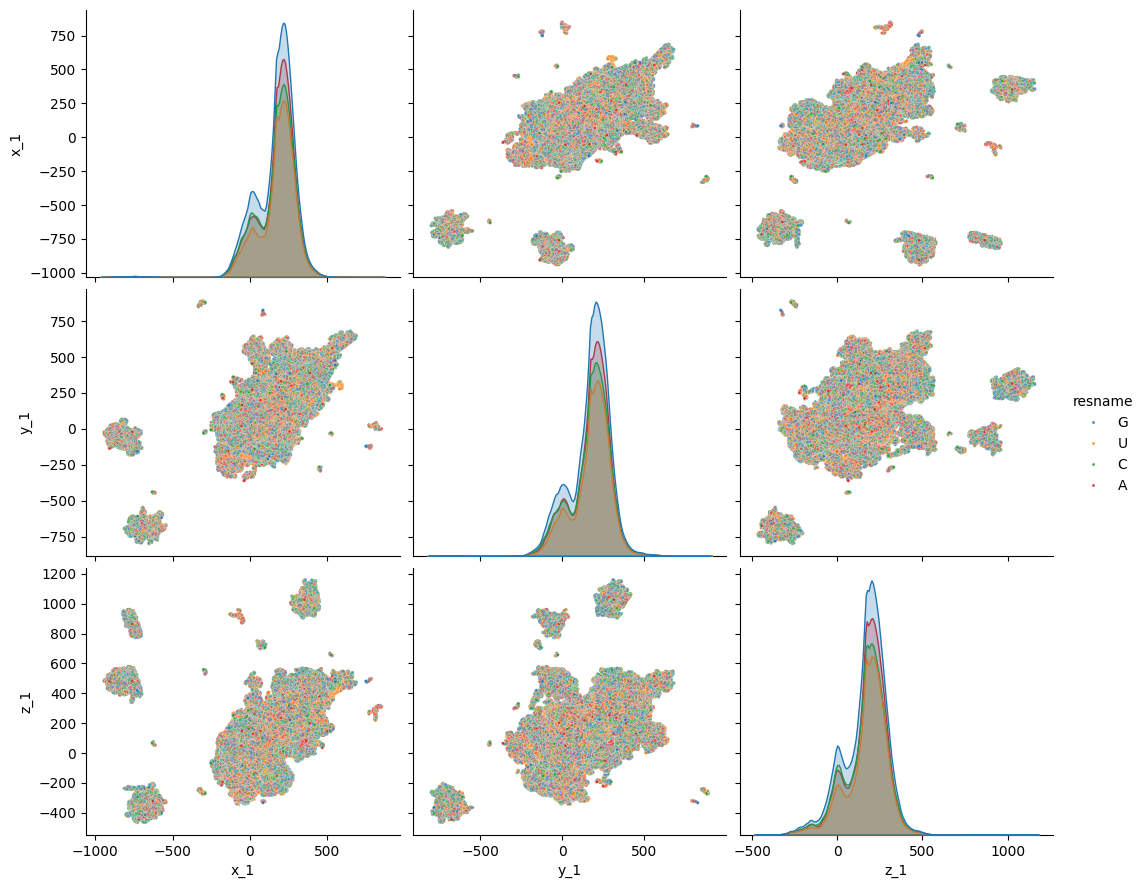

In [33]:
default_color_1 = 'darkblue'
if RECREATE_PLOTS: 
    sns.pairplot(data=train_labels[['x_1', 'y_1', 'z_1','resname']],
                hue = 'resname',
                diag_kws = {'color' : default_color_1},
                plot_kws = {'s' : 5, 
                            'alpha' : 0.8,
                            'color' : default_color_1},
                                height=3,
                                aspect=1.2
                            )
    plt.show()

The majority of coordinates seem to be in a common range but there are some outliers 

Let's find out if the length of the sequence correlates with the coordinate range and residue distance

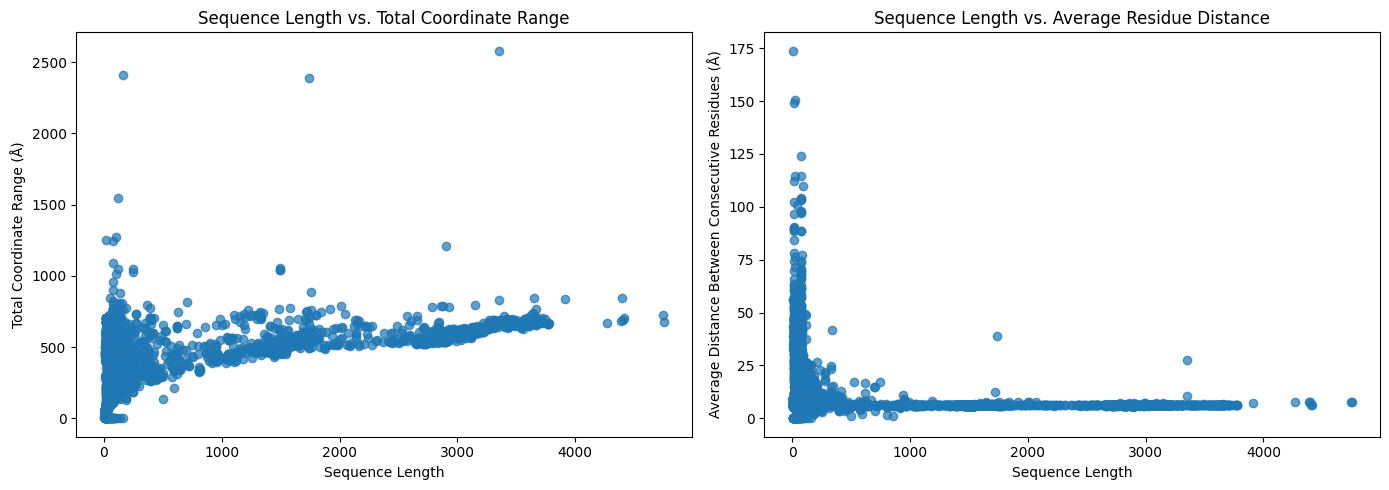

In [34]:
train_labels_copy = train_labels.copy()
idx = train_labels_copy.sequence_id.unique()

# create a dataframe to store the statistics about sequence length, coordinate range, and average residue distance
stats_df = pd.DataFrame()
if RECREATE_PLOTS:
    for i in range(len(idx)):
        tmp = train_labels_copy.loc[train_labels_copy.sequence_id == idx[i]].reset_index(drop=True)
        sequence_length = len(tmp)
        x_range = tmp.x_1.max() - tmp.x_1.min()
        y_range = tmp.y_1.max() - tmp.y_1.min()
        z_range = tmp.z_1.max() - tmp.z_1.min()

        distances = []
        for index, row in tmp.iterrows():
            if index < len(tmp) - 1:
                next_row = tmp.loc[index + 1]
                distance = np.sqrt((row.x_1 - next_row.x_1)**2 + (row.y_1 - next_row.y_1)**2 + (row.z_1 - next_row.z_1)**2)
                distances.append(distance)
        mean_distance = np.mean(distances)

        stats_df = pd.concat([stats_df, pd.DataFrame({
                    'RNA_ID': [idx[i]],
                    'Sequence_Length': [sequence_length],
                    'X_Range': [x_range],
                    'Y_Range': [y_range],
                    'Z_Range': [z_range],
                    'Avg_Residue_Distance': [mean_distance]
                })])

    # plot the statistics
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(stats_df['Sequence_Length'], stats_df['X_Range'] + stats_df['Y_Range'] + stats_df['Z_Range'], alpha=0.7)
    plt.title('Sequence Length vs. Total Coordinate Range')
    plt.xlabel('Sequence Length')
    plt.ylabel('Total Coordinate Range (Å)')

    plt.subplot(1, 2, 2)
    plt.scatter(stats_df['Sequence_Length'], stats_df['Avg_Residue_Distance'], alpha=0.7)
    plt.title('Sequence Length vs. Average Residue Distance')
    plt.xlabel('Sequence Length')
    plt.ylabel('Average Distance Between Consecutive Residues (Å)')

    plt.tight_layout()
    plt.show()

> As expected, the sequence length correlates with the coordinate range. There seems to be no correlation between sequence length and avg residue distance

### Findings of initial EDA 

- longest sequence in train set is 4298 residues
- longest sequence in validation set is 720 residues
- most sequences are < 200 residues
- G is most common
- Validation set has 40 3d structures for each sequence
- The validation sequences are on average longer
- sequence length correlates with the coordinate range but not with avg residue distance
- There were missing values in the train_labels and train_sequences which have been handled already



## Baseline Model

The first baseline model will be a simple CNN architecture. The purpose of the baseline model is to gain understanding of the data and also to have a first model to compare future models and improvements to.


### Data preprocessing

Since the sequences have variable length, we have to pad them to the same length for our CNN model

In [35]:
# the desired uniform length for all sequences
max_length = train_sequences["sequence"].str.len().max()

In [36]:
train_labels["sequence_id"] = train_labels["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))
train_sequences = train_sequences.drop_duplicates( subset='target_id', keep='first')
train_labels = train_labels.drop_duplicates(subset='ID', keep='first')
train_sequences['seq_length'] = train_sequences['sequence'].apply(lambda x: len(x))
train_labels['seq_length'] = train_labels['sequence_id'].map(train_labels['sequence_id'].value_counts())

In [37]:
# pad the sequences
padded_sequences_train = train_sequences[["sequence","target_id"]]
padded_sequences_train.loc[:, "sequence"] = padded_sequences_train['sequence'].str.pad(width=max_length, side='right', fillchar='0')

padded_sequences_valid = valid_sequences[["sequence","target_id"]]
padded_sequences_valid.loc[:, "sequence"] = padded_sequences_valid['sequence'].str.pad(width=max_length, side='right', fillchar='0')

# convert them to dictionaries
padded_sequences_train_dict = {row['target_id']: row['sequence'] for index, row in padded_sequences_train.iterrows()}
padded_sequences_valid_dict = {row['target_id']: row['sequence'] for index, row in padded_sequences_valid.iterrows()}

print(len(padded_sequences_train_dict))
print(len(padded_sequences_valid_dict))

5379
12


In [38]:
# pad the labels and convert them to dictionaries
def pad_coordinate_sequence(array, desired_length):
    num_padding = desired_length - len(array)
    padding = np.zeros((num_padding, 3), dtype=int)
    padded_array = np.concatenate((array,padding),axis=0)
    return padded_array

def pad_labels(labels_df, target_length):
    """
    Processes a labels DataFrame by grouping rows by target_id.
    Returns a dictionary mapping target_id to an array of coordinates (seq_len, 3).
    """
    label_dict = {}
    for idx, row in labels_df.iterrows():
        # Split ID into target_id and residue number (assumes format "targetid_resid")
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        # Extract the coordinates; they should be numeric (missing values already set to 0)
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    
    # Sort residues by resid and stack coordinates
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    label_dict_padded = {k: pad_coordinate_sequence(v,target_length) for k, v in label_dict.items()}
    return label_dict_padded

padded_labels_train_dict = pad_labels(train_labels, max_length)
padded_labels_valid_dict = pad_labels(valid_labels, max_length)
print(len(padded_labels_train_dict))
print(len(padded_labels_valid_dict))


5379
12


Now we convert the data to tensors, so that we can feed them into the deep learning model

In [39]:
# encode the sequences with integers

residue_encoding = {'A': 1, 'C': 2, 'G': 3, 'U': 4, '0': 0}
padded_sequences_train_dict = {k: [residue_encoding[res] for res in v] for k, v in padded_sequences_train_dict.items()}
padded_sequences_valid_dict = {k: [residue_encoding[res] for res in v] for k, v in padded_sequences_valid_dict.items()}

In [40]:
def convert_data_to_tensors(sequence_dict, label_dict):
    sequence_tensors = []
    labels_tensors = []

    for key in label_dict:
        sequence = sequence_dict[key]
        sequence_tensor = torch.tensor(sequence)
        sequence_tensors.append(sequence_tensor)   
        labels_tensor = torch.tensor(label_dict[key], dtype=torch.float32)
        labels_tensors.append(labels_tensor)

    # Stack the tensors
    inputs = torch.stack(sequence_tensors)
    targets = torch.stack(labels_tensors)
    return inputs, targets

inputs_train, targets_train = convert_data_to_tensors(padded_sequences_train_dict, padded_labels_train_dict)
inputs_valid, targets_valid = convert_data_to_tensors(padded_sequences_valid_dict, padded_labels_valid_dict)
print(f"Input tensor shape (train): {inputs_train.shape}")
print(f"Input tensor shape (valid): {inputs_valid.shape}")
print(f"Target tensor shape (train): {targets_train.shape}")
print(f"Target tensor shape (valid): {targets_valid.shape}")

Input tensor shape (train): torch.Size([5379, 4417])
Input tensor shape (valid): torch.Size([12, 4417])
Target tensor shape (train): torch.Size([5379, 4417, 3])
Target tensor shape (valid): torch.Size([12, 4417, 3])


Last but not least, instead of representing each residue with a number between 0 and 4 we one hot encode each residue. The coordinates in each entry are normalized so that the residue numbers start from 1 and are consecutive. This means that residue 5 does not necessarily correspond to the 5th residue in the sequence, but rather to a specific residue. Each residue number is mapped to a specific residue in the sequence representing this residue, so that there is no bias towards residues with higher numbers.

In [41]:
inputs_train = F.one_hot(inputs_train, num_classes=5)
inputs_train = inputs_train.to(torch.float32)
inputs_valid = F.one_hot(inputs_valid, num_classes=5)
inputs_valid = inputs_valid.to(torch.float32)

### Create Dataset and Dataloaders

In [42]:
class RNASequenceDataset(Dataset):
    """Simple single input tensor and single target tensor dataset.
    """

    def __init__(self, inputs: Tensor, targets: Tensor)  -> None:
        self.inputs = inputs
        self.targets = targets

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        return self.inputs[index], self.targets[index]
    
    def __len__(self) -> int:
        return self.inputs.shape[0]


In [43]:
inputs_combined = torch.cat((inputs_train, inputs_valid), dim=0)
targets_combined = torch.cat((targets_train, targets_valid), dim=0)
# split the combined dataset into train and validation sets
dataset = RNASequenceDataset(inputs_combined, targets_combined)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
ds_train, ds_valid = torch.utils.data.random_split(dataset, [train_size, val_size]) 
len(ds_train), len(ds_valid)

(4312, 1079)

In [44]:
# for custom training loop
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=16, shuffle=True)

### Loss function

Now we'll have a look at the loss function. Since we're predicting 3D coordinates, we'll use the Root Mean Squared Error (RMSE) as our loss function. However, since the 3D coordinates are invariant to rotation, we'll need to use the Kabsch algorithm, an algorithm to find the optimal rotation that minimizes the RMSE between two sets of points. For alignment of the 3D structure, we use the Singular Value Decomposition (SVD) method for the covariance matrix of the two structures (https://en.wikipedia.org/wiki/Kabsch_algorithm). Here is how it works:

1. Centroid Computation: Compute the centroids (mean values) of the input and target data.

2. Centering: Center the input and target data by subtracting their respective centroids.

3. Covariance Matrix Computation: Compute the covariance matrix between the centered input and target data.

4. SVD: Perform SVD on the covariance matrix to find the optimal rotation matrix.

5. Rotation Matrix Computation: Compute the rotation matrix from the SVD results.

6. Rotation Check: Check if the rotation matrix represents a proper rotation (i.e., no reflection). If not, adjust the rotation matrix accordingly.

7. Alignment: Apply the rotation matrix to the centered input data to align it with the target data.

8. We use root mean square deviation (RMSD) for calculating the loss between the two 3d structures

Let's implement and visualize the alignment algorithm. First we create some helper functions for rotating a point cloud and for visualization:

In [45]:
def euler_to_rotation_matrix(roll: float, pitch :float, yaw:float) -> torch.Tensor: 
    """
    Convert Euler angles to a rotation matrix.

    Args:
        roll (float): Roll angle in radians.
        pitch (float): Pitch angle in radians.
        yaw (float): Yaw angle in radians.

    Returns:
        torch.Tensor: Rotation matrix.
    """
    Rx = torch.tensor([
        [1, 0, 0],
        [0, math.cos(roll), -math.sin(roll)],
        [0, math.sin(roll), math.cos(roll)]
    ])

    Ry = torch.tensor([
        [math.cos(pitch), 0, math.sin(pitch)],
        [0, 1, 0],
        [-math.sin(pitch), 0, math.cos(pitch)]
    ])

    Rz = torch.tensor([
        [math.cos(yaw), -math.sin(yaw), 0],
        [math.sin(yaw), math.cos(yaw), 0],
        [0, 0, 1]
    ])

    return torch.mm(torch.mm(Rz, Ry), Rx)

def rotate_tensor(tensor : torch.Tensor, rotation_matrix : torch.Tensor) -> torch.Tensor:
    """
    Rotate a tensor by applying a rotation matrix.
    """
    return torch.mm(tensor, rotation_matrix)


def draw_comparison_plots(point_cloud_1 : torch.Tensor, point_cloud_2 : torch.Tensor, title )-> None:
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])
    fig.add_trace(
        go.Scatter3d(
            x=point_cloud_1[:, 0],
            y=point_cloud_1[:, 1],
            z=point_cloud_1[:, 2],
            mode='markers'
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter3d(
            x=point_cloud_2[:, 0],
            y=point_cloud_2[:, 1],
            z=point_cloud_2[:, 2],
            mode='markers'
        ),
        row=1, col=2
    )
    fig.update_layout(
        scene = dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
            ),
        scene2 = dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'),
        title=title
    )
    fig.show()

Now we create a random point cloud that simulates our predicted structure. Since we will work with batches of data, we simulate a batch of size 1

In [46]:
# Define a random point cloud tensor
predicted_coords = torch.randn(1,5, 3)
print(predicted_coords.shape)
predicted_coords

torch.Size([1, 5, 3])


tensor([[[-0.3877, -0.0936,  0.6446],
         [ 0.7456, -0.5053,  0.4967],
         [ 1.0400, -1.0584, -0.2093],
         [ 1.0049, -1.0616,  0.5513],
         [ 0.9154, -2.0768,  1.8203]]])

Now we create a copy with a little bit of variation in the coordinates and some rotation. This simulates the target structure (ground truth)

torch.Size([1, 5, 3])
Initial RMSD: 3.161590099334717


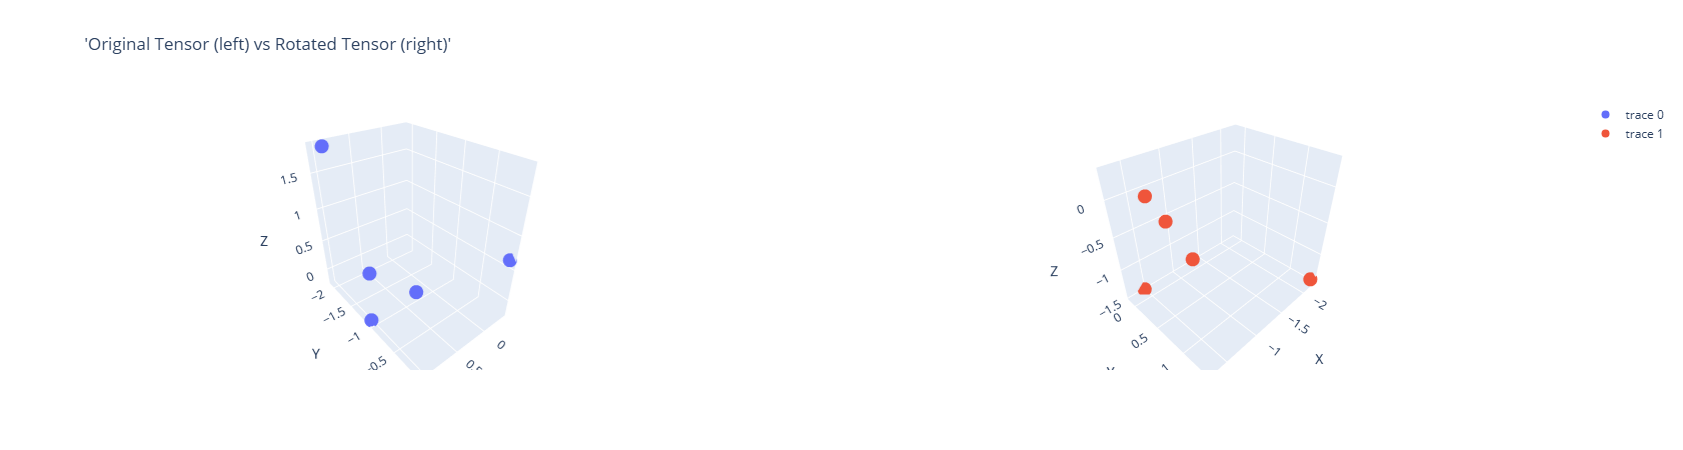

In [141]:
# create a second point cloud with a little bit of variation
noise_std = 0.05
noise = torch.randn_like(predicted_coords) * noise_std
target_coords = predicted_coords + noise
print(target_coords.shape)
target_coords

# add rotation
rotation_matrix = euler_to_rotation_matrix(math.pi / 4, 1, 3)
rotation_matrix.shape
tmp = target_coords.squeeze(0)
tmp = rotate_tensor(tmp, rotation_matrix)
target_coords =  tmp.unsqueeze(0)

# show plots
inital_rmsd = torch.sqrt(torch.sum(torch.square(predicted_coords - target_coords), dim=(1, 2)) / predicted_coords.shape[1])
print(f"Initial RMSD: {inital_rmsd.item()}")
if INTERACTIVE_PLOTS:
    draw_comparison_plots(predicted_coords.squeeze(0),target_coords.squeeze(0),"'Original Tensor (left) vs Rotated Tensor (right)'")
else:
    display(Image("images/originalVSrotated.png"))

Now we use the alignment algorithm to align the point clouds and see how that changes the rmse

RMSD after alignment: 0.06353216618299484


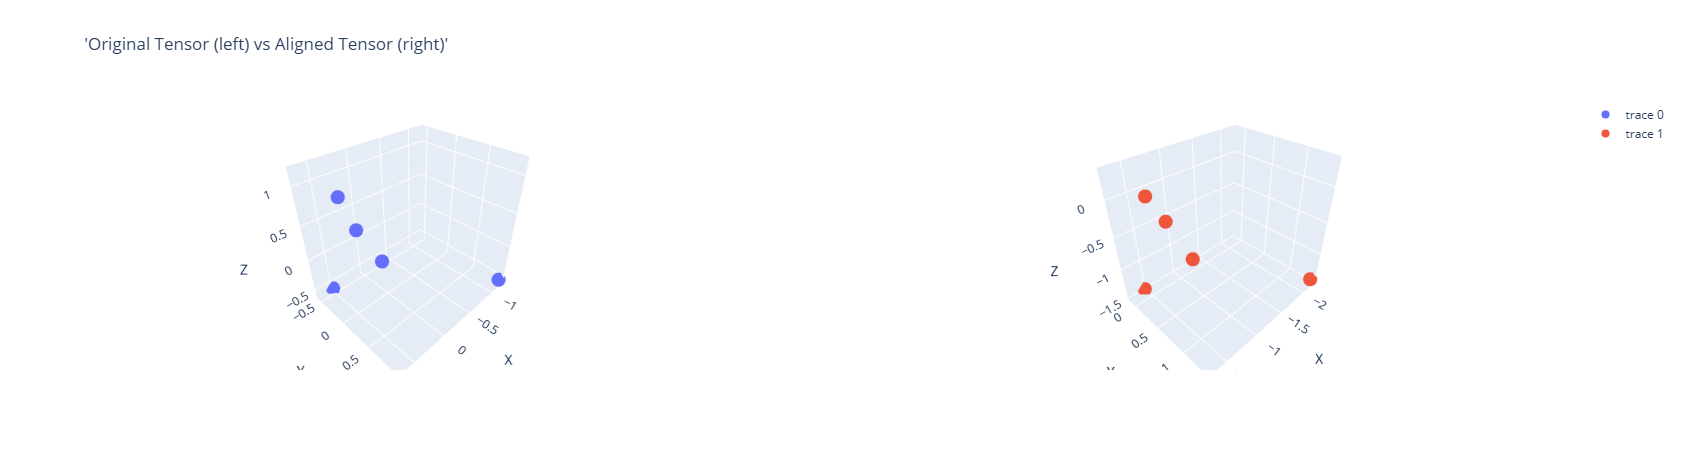

In [142]:
# Compute centroids
centroid_P = torch.mean(predicted_coords, dim=1, keepdims=True)  # BxNx3
centroid_Q = torch.mean(target_coords, dim=1, keepdims=True)  # BxNx3

# Center the points
p = predicted_coords - centroid_P  # BxNx3
q = target_coords - centroid_Q  # BxNx3

# Compute the covariance matrix
H = torch.matmul(p.transpose(1, 2), q)  # Bx3x3

# SVD
U, S, Vt = torch.linalg.svd(H)  # Bx3x3

# Validate right-handed coordinate system
d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2)))  # B
flip = d < 0.0
if flip.any().item():
    Vt[flip, -1] *= -1.0

# Optimal rotation
R = torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))
R
aligned_coords = torch.matmul(p, R.transpose(1, 2))
aligned_rmsd = torch.sqrt(torch.sum(torch.square(aligned_coords - q), dim=(1, 2)) / predicted_coords.shape[1])

print(f"RMSD after alignment: {aligned_rmsd.item()}")
if INTERACTIVE_PLOTS:
    draw_comparison_plots(aligned_coords.squeeze(0),target_coords.squeeze(0),"'Original Tensor (left) vs Aligned Tensor (right)'")
else:
    display(Image("images/originalVSrotated_aligned.png"))

> ->After alignment the rotation is identical and the RMSE is reduced significantly

### Create a simple baseline model

In [49]:
# get a minibatch to test the model input and output shapes
test_batch = next(iter(dl_train))[0]
test_batch.shape

torch.Size([16, 4417, 5])

In [50]:
class Reshape(nn.Module ):
    def forward(self, x):
        return x.permute(0, 2, 1)
    
sequence_length = max_length

baselineModel = lambda: nn.Sequential(
    Reshape(),
    
    nn.Conv1d(in_channels=5, out_channels=3, kernel_size=3, padding=1),
    nn.BatchNorm1d(3),
    nn.ReLU(),
    nn.Dropout(0.1),

    nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3, padding=1),
    nn.BatchNorm1d(3),
    nn.ReLU(),
    
    nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3, padding=1),
    Reshape()
)

model = baselineModel()
model(test_batch).shape

torch.Size([16, 4417, 3])

### Training

First define the loss function using the kabsch algorithm we expored before, in a way that is compatible with pytorch

In [51]:
class Kabsch_loss(nn.Module):    
    
    def __init__(self):
        super(Kabsch_loss, self).__init__()

    def forward(self, predictions : Tensor, targets : Tensor) -> Tensor:
        """
        Computes the optimal rotation and translation to align two sets of points (P -> Q),
        and returnes the RMSD, in a batched manner.
        :param P: A BxNx3 matrix of points
        :param Q: A BxNx3 matrix of points
        :return: The RMSD after optimal alignment.
        """
        assert predictions.shape == targets.shape, "Matrix dimensions must match"

        # Compute centroids
        centroid_P = torch.mean(predictions, dim=1, keepdims=True)  # BxNx3
        centroid_Q = torch.mean(targets, dim=1, keepdims=True)  # BxNx3

        # Center the points
        p = predictions - centroid_P  # BxNx3
        q = targets - centroid_Q  # BxNx3

        # Compute the covariance matrix
        H = torch.matmul(p.transpose(1, 2), q)  # Bx3x3

        # SVD
        U, S, Vt = torch.linalg.svd(H)  # Bx3x3

        # Validate right-handed coordinate system
        d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2)))  # B
        flip = d < 0.0
        if flip.any().item():
            Vt = Vt.clone()
            Vt[flip, -1] *= -1.0

        # Optimal rotation
        R = torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))

        # RMSD
        rmsd = torch.sqrt(torch.sum(torch.square(torch.matmul(p, R.transpose(1, 2)) - q), dim=(1, 2)) / predictions.shape[1])
        return rmsd.mean()


Now we define the training loop

In [52]:
def train(
    model: nn.Module,
    dl_train: DataLoader,
    dl_valid: DataLoader,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    n_epochs: int,
    lr_scheduler : any = None,
) -> None:
    
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(n_epochs)):
        ep_train_loss = train_one_epoch(model, dl_train, optimizer, loss_fn)
        train_losses.append(ep_train_loss)
        ep_val_loss = validate_one_epoch(model, dl_valid, loss_fn)
        valid_losses.append(ep_val_loss)
        if lr_scheduler is not None:
            lr_scheduler.step()
            

    print(train_losses)
    print(valid_losses)
    plt.plot(train_losses)
    plt.plot(valid_losses)
    plt.legend(["Train Loss", "Valid Loss"])
    plt.xlabel("Epoch")
    plt.grid(True, axis="y")
    #plt.ylim([0, 1])
    print(f"Final Loss: {valid_losses[-1]}")


def train_one_epoch(model: nn.Module, dl_train: DataLoader, optimizer: Optimizer, loss_func: nn.Module) -> float:
    model.train()
    running_train_loss = 0.0
    n_samples = 0
    for inputs, targets in dl_train:
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_func(predictions, targets)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_train_loss += loss.item() * batch_size
        n_samples += batch_size

    return running_train_loss / n_samples

def validate_one_epoch(model: nn.Module, dl_valid: DataLoader, loss_func: nn.Module) -> float:
    model.eval()
    running_valid_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for inputs, targets in dl_valid:
            predictions = model(inputs)
            loss = loss_func(predictions, targets)

            batch_size = inputs.size(0)
            running_valid_loss += loss.item() * batch_size
            n_samples += batch_size

    return running_valid_loss / n_samples

Train the model

In [53]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=16, shuffle=True)
model = baselineModel()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optim, max_lr=1e-3, total_steps=30, pct_start=0.3)

if BASELINE_TRAINING_ENABLED:
    train(model,dl_train=dl_train,dl_valid=dl_valid, optimizer=optim, loss_fn=Kabsch_loss(), n_epochs=30, lr_scheduler=scheduler)

### First submission

In [54]:
submission = pd.read_csv(SAMPLE_SUB_PATH)

Preprocess the test sequences

In [55]:
# pad the sequences
padded_sequences_test = test_sequences[["sequence","target_id"]]
padded_sequences_test.loc[:, "sequence"] = padded_sequences_test['sequence'].str.pad(width=max_length, side='right', fillchar='0')

# convert them to dictionaries
sequences_test_dict = {row['target_id']: row['sequence'] for index, row in test_sequences.iterrows()}
padded_sequences_test_dict = {row['target_id']: row['sequence'] for index, row in padded_sequences_test.iterrows()}

# encode the sequences with integers
residue_encoding = {'A': 1, 'C': 2, 'G': 3, 'U': 4, '0': 0}
padded_sequences_test_dict = {k: [residue_encoding[res] for res in v] for k, v in padded_sequences_test_dict.items()}

convert them to tensors

In [56]:
sequence_tensors = []
keys = []

for key in padded_sequences_test_dict:
    sequence = padded_sequences_test_dict[key]
    sequence_tensor = torch.tensor(sequence)
    sequence_tensors.append(sequence_tensor)   
    keys.append(key)

inputs_test = torch.stack(sequence_tensors)

one hot encoding

In [57]:
inputs_test = F.one_hot(inputs_test, num_classes=5)
inputs_test = inputs_test.to(torch.float32)

get the predictions

In [ ]:
model.eval()
submission_df = pd.DataFrame(columns=['ID', 'x_1', 'y_1', 'z_1'])
for idx,value in enumerate(keys):
    prediction = model(inputs_test[idx].unsqueeze(0))
    prediction = prediction.squeeze(0)
    df = pd.DataFrame(prediction, columns=['x_1', 'y_1', 'z_1'])
    df['ID'] = [f"{keys[idx]}_{i}" for i in range(1, len(df) + 1)]
    columns = ['ID'] + [col for col in df.columns if col != 'ID']
    df = df[columns]
    df = df[:len(sequences_test_dict[value])]
    submission_df = pd.concat([submission_df, df], ignore_index=True)

duplicate predictions 5 times, because the submit format expects 5 predictions per residue

In [59]:
for i in range(2, 6):
    for axis in ['x', 'y', 'z']:
        submission_df[f"{axis}_{i}"] = submission_df[f"{axis}_1"].copy()

write the predictions to the sample submission dataframe

In [60]:
for i in range(1, 6):
    mapping = submission_df.set_index('ID')[f'x_{i}']
    submission[f'x_{i}'] = submission['ID'].map(mapping)
    mapping = submission_df.set_index('ID')[f'y_{i}']
    submission[f'y_{i}'] = submission['ID'].map(mapping)
    mapping = submission_df.set_index('ID')[f'z_{i}']
    submission[f'z_{i}'] = submission['ID'].map(mapping)

submission.head()

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,-0.363056,0.311165,0.310982,-0.363056,0.311165,0.310982,-0.363056,0.311165,0.310982,-0.363056,0.311165,0.310982,-0.363056,0.311165,0.310982
1,R1107_2,G,2,-0.294778,0.362814,0.339249,-0.294778,0.362814,0.339249,-0.294778,0.362814,0.339249,-0.294778,0.362814,0.339249,-0.294778,0.362814,0.339249
2,R1107_3,G,3,-0.325033,0.334907,0.322375,-0.325033,0.334907,0.322375,-0.325033,0.334907,0.322375,-0.325033,0.334907,0.322375,-0.325033,0.334907,0.322375
3,R1107_4,G,4,-0.336442,0.338495,0.311975,-0.336442,0.338495,0.311975,-0.336442,0.338495,0.311975,-0.336442,0.338495,0.311975,-0.336442,0.338495,0.311975
4,R1107_5,G,5,-0.372700,0.320986,0.303398,-0.372700,0.320986,0.303398,-0.372700,0.320986,0.303398,-0.372700,0.320986,0.303398,-0.372700,0.320986,0.303398


### Another simple model

In [61]:
# get a minibatch to test the model input and output shapes
test_batch = next(iter(dl_train))[0]
test_batch.shape

torch.Size([16, 4417, 5])

This time we flatten the input so that the sequence is represented by all one-hot encodings in a sequence.

In [62]:
class Unsqueeze(nn.Module ):
    def forward(self, x):
        return x.unsqueeze(1)

baseline_model_flatten = lambda: nn.Sequential(  
    Unsqueeze(), 
    nn.Flatten(2), 
    nn.Conv1d(in_channels=1, out_channels=3, kernel_size=5, padding=2),
    nn.BatchNorm1d(3),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=3, out_channels=3, kernel_size=5, padding=2, stride=5),
    Reshape(),   
)

model = baseline_model_flatten()
model(test_batch).shape

torch.Size([16, 4417, 3])

In [63]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=16, shuffle=True)
model = baseline_model_flatten()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optim, max_lr=1e-3, total_steps=30, pct_start=0.3)
if BASELINE_TRAINING_ENABLED:
    train(model,dl_train=dl_train,dl_valid=dl_valid, optimizer=optim, loss_fn=Kabsch_loss(), n_epochs=30, lr_scheduler=scheduler)

## Get data for pre-training

As mentioned before, the main objective is create a Transformer based model for this problem. A Transformer generally benefits from pre-training it on large scale datasets.
In our case, we use a synthetically created dataset containing 600 000 sequences. The dataset was provided by the developers of RFdiffusion. It consists of computationally generated structures, to help RNA structure-prediction models learn stereochemistry early in training. [Read more](https://www.kaggle.com/datasets/andrewfavor/uw-synthetic-rna-structures)

Since transformer models are very data hungry, we use this dataset for pretraining of the weights. After pretraining we then finetune the weights using the experimentally verified dataset from before

### Parse the Protein database files

Parse the pdb files to pickles

In [64]:
from data_utils import pdb_util

if PDB_PROCESSING_ENABLED:
    for folder in  os.listdir(PRETRAIN_DATASET_DIR):
        folder_path = os.path.join(PRETRAIN_DATASET_DIR, folder)
        if os.path.isdir(folder_path):
           pdb_util.process_folder(folder_path, PICKLE_DIR_BASE )
        else:
            print(f"Skipping {folder_path}, not a directory.")

Combine the pickles into batches of data

In [65]:
if PDB_PROCESSING_ENABLED:
    pdb_util.combine_pickle_files_in_batches(PICKLE_FOLDER_TARGETS, batch_size=50, output_prefix="targets_batch")
    pdb_util.combine_pickle_files_in_batches(PICKLE_FOLDER_SEQUENCES, batch_size=50, output_prefix="sequences_batch")

### Mini EDA

In [66]:
BATCH_NUMBER = 1

In [67]:
sequences_batch =pd.read_pickle(f"{PICKLE_DIR_BASE}/batches/sequences_batch_{BATCH_NUMBER}.pkl")
targets_batch = pd.read_pickle(f"{PICKLE_DIR_BASE}/batches/targets_batch_{BATCH_NUMBER}.pkl")

In [68]:
sequences_batch.head()

,sequence_id,sequence
0,cppc_0000001,UUUUUUUUUUUUUUUUUUUUAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCUUUUUUUUUUUUUUUUUUUUGGGGGGGGGGGGGGGGGGGGGGGAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCUUUUUUUUUUUUUUUUUUUUAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGUUUUUUUUUUUUUUUUUUUUA...
1,cppc_0000002,AAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCC...
2,cppc_0000003,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGUUUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGG...
3,cppc_0000004,UUUUUUUUUUUUUUUUUUUUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGUUUUUUUUUUUUUUUUUUUUGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGUUUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCUUUUUUUUUUUUUUUUUUUU...
4,cppc_0000005,UUUUUUUUUUUUUUUUUUUUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUUUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGAAAAAAAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGUUUUUUUUUUUUUUUUU...


In [69]:
targets_batch.head()

,resname,x_1,y_1,z_1,resid,sequence_id,ID
0,U,-56.922,6.213,-18.966,1,cppc_0000001,cppc_0000001_1
1,U,-56.039,7.287,-18.558,2,cppc_0000001,cppc_0000001_2
2,U,-56.462,5.162,-19.923,3,cppc_0000001,cppc_0000001_3
3,U,-57.557,5.519,-17.706,4,cppc_0000001,cppc_0000001_4
4,U,-58.108,6.295,-16.679,5,cppc_0000001,cppc_0000001_5


In [70]:
targets_batch.describe()

,x_1,y_1,z_1,resid
count,1.811671e+08,1.811671e+08,1.811671e+08,1.811671e+08
mean,3.864882e-01,3.263363e-01,2.542006e-01,2.127458e+03
std,2.066752e+01,2.002361e+01,1.954187e+01,1.441235e+03
min,-1.339120e+02,-9.999500e+01,-9.999900e+01,1.000000e+00
25%,-1.268600e+01,-1.257200e+01,-1.245600e+01,9.060000e+02
50%,2.580000e-01,3.530000e-01,2.420000e-01,1.867000e+03
75%,1.333100e+01,1.326800e+01,1.291100e+01,3.270000e+03
max,1.238830e+02,1.149020e+02,1.105410e+02,5.323000e+03


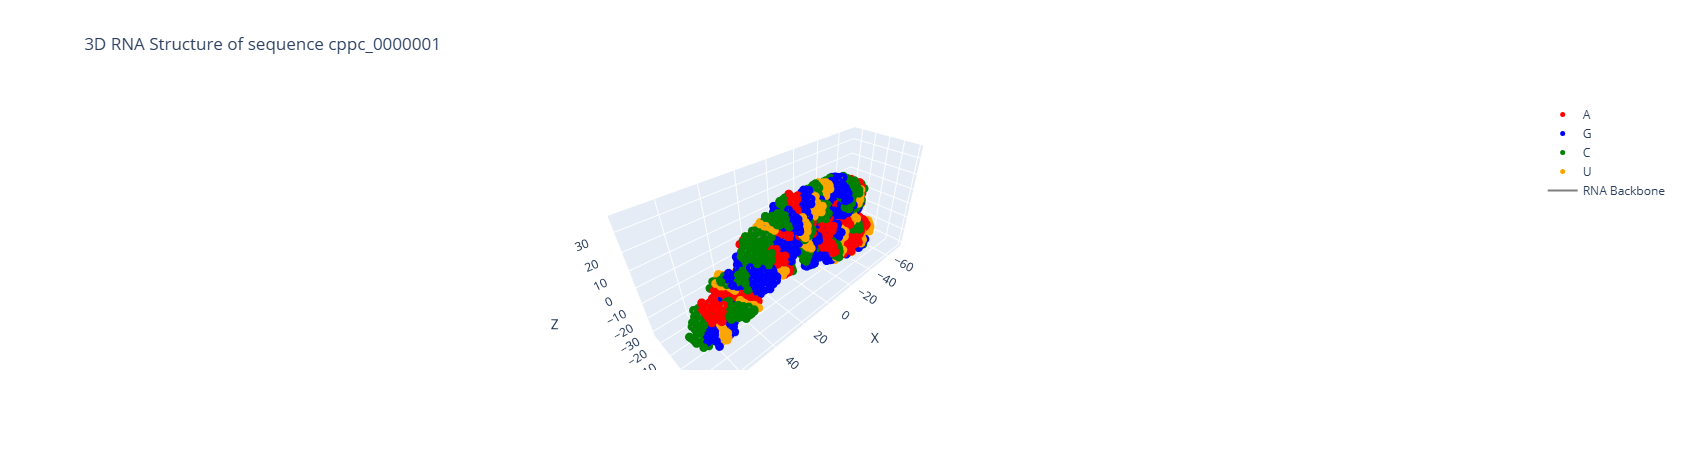

In [143]:
if INTERACTIVE_PLOTS:
    plot_structure(targets_batch, "cppc_0000001")
else: 
    display(Image("images/cppc_0000001.png"))

In [72]:
targets_batch.sequence_id.value_counts().mean()

np.float64(3623.34186)

Text(0, 0.5, 'Count')

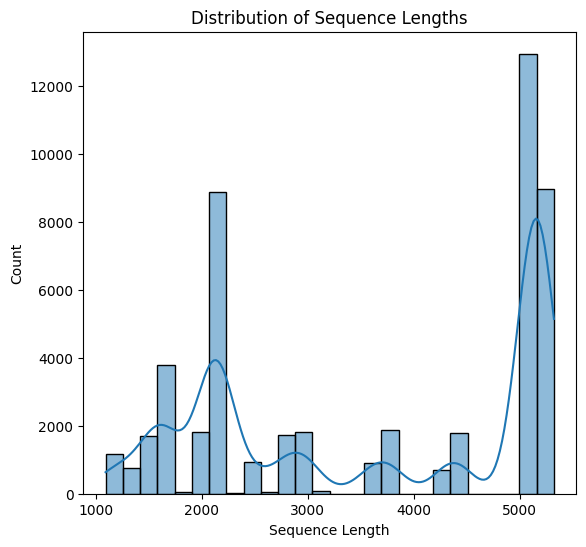

In [73]:
sequences_batch['seq_length'] = sequences_batch['sequence'].apply(len)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(sequences_batch['seq_length'], kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')

In [74]:
sequences_batch['seq_length'].describe()

count    50000.000000
mean      3623.341860
std       1511.566453
min       1094.000000
25%       2143.000000
50%       3762.000000
75%       5151.000000
max       5323.000000
Name: seq_length, dtype: float64

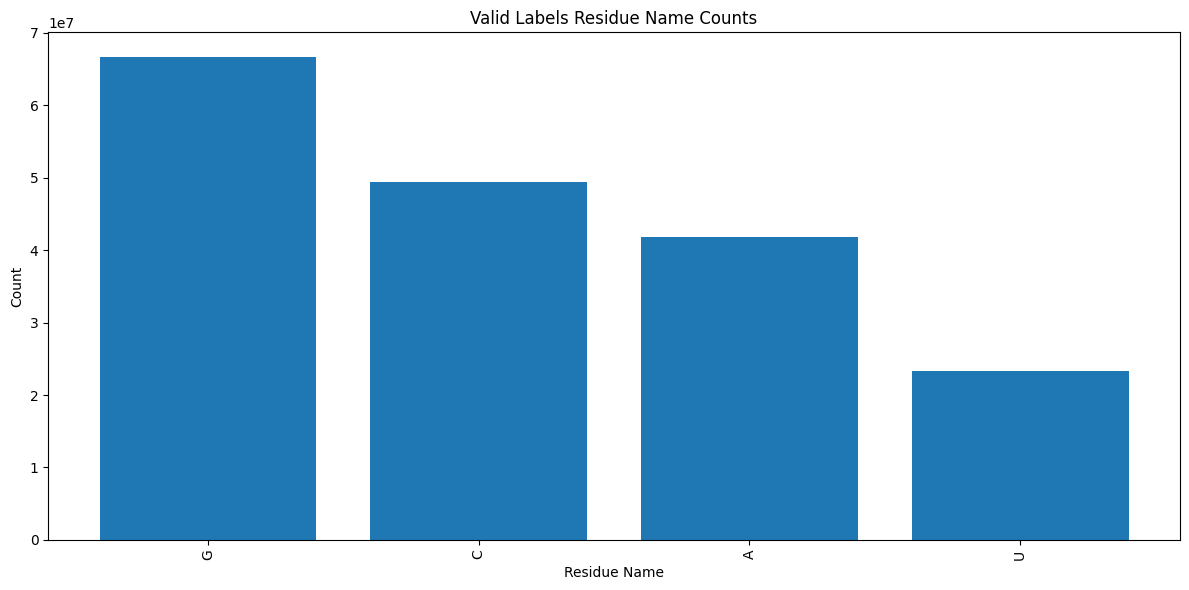

In [75]:
counts = targets_batch.resname.value_counts()

plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.title('Valid Labels Residue Name Counts')
plt.xlabel('Residue Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

In [76]:
sequences_batch =pd.read_pickle(f"{PICKLE_DIR_BASE}/batches/sequences_batch_{BATCH_NUMBER}.pkl")
targets_batch = pd.read_pickle(f"{PICKLE_DIR_BASE}/batches/targets_batch_{BATCH_NUMBER}.pkl")

### Preprocessing

In [77]:
from data_utils import preprocessing_util

if PDB_PROCESSING_ENABLED:
    preprocessing_util.check_for_missing_values(sequences_batch, targets_batch)
    sequences_batch.rename(columns={'sequence_id': 'target_id'}, inplace=True)
    sequences = sequences_batch[["sequence","target_id"]]
    sequences_dict= {row['target_id']: row['sequence'] for index, row in sequences.iterrows()}
    labels_dict = preprocessing_util.convert_labels_to_dict(targets_batch)
    residue_encoding = {'A': 1, 'C': 2, 'G': 3, 'U': 4, '0': 0}
    sequences_dict = {k: [residue_encoding[res] for res in v] for k, v in sequences_dict.items()}
    inputs, targets = preprocessing_util.convert_to_list_of_tensors(sequences_dict, labels_dict)
    with open(f'{PICKLE_DIR}/inputs_{BATCH_NUMBER}.pkl', 'wb') as f:
        pickle.dump(inputs, f)

    with open(f'{PICKLE_DIR}/targets_{BATCH_NUMBER}.pkl', 'wb') as f:
        pickle.dump(targets, f)

## RNA Transformer V1
-- Trained on Kaggle GPU P100 --

This approach uses a basic transformer architecture with encoder and decoder. In the encoder, first an embedding is created. Then positional encoding and self-attention features are added. The decoder takes the target coordinates and extracts a feature vector from them using a fully connected layer. The number of features is the same as the number of embedding features in the encoder. After the fc-layer, positional encoding and self-attention is added, as well as attention regarding the encoder output in form of a standard encoder-decoder attention block. The resulting features then go trough a fully connected layer which predicts the next target coordinates

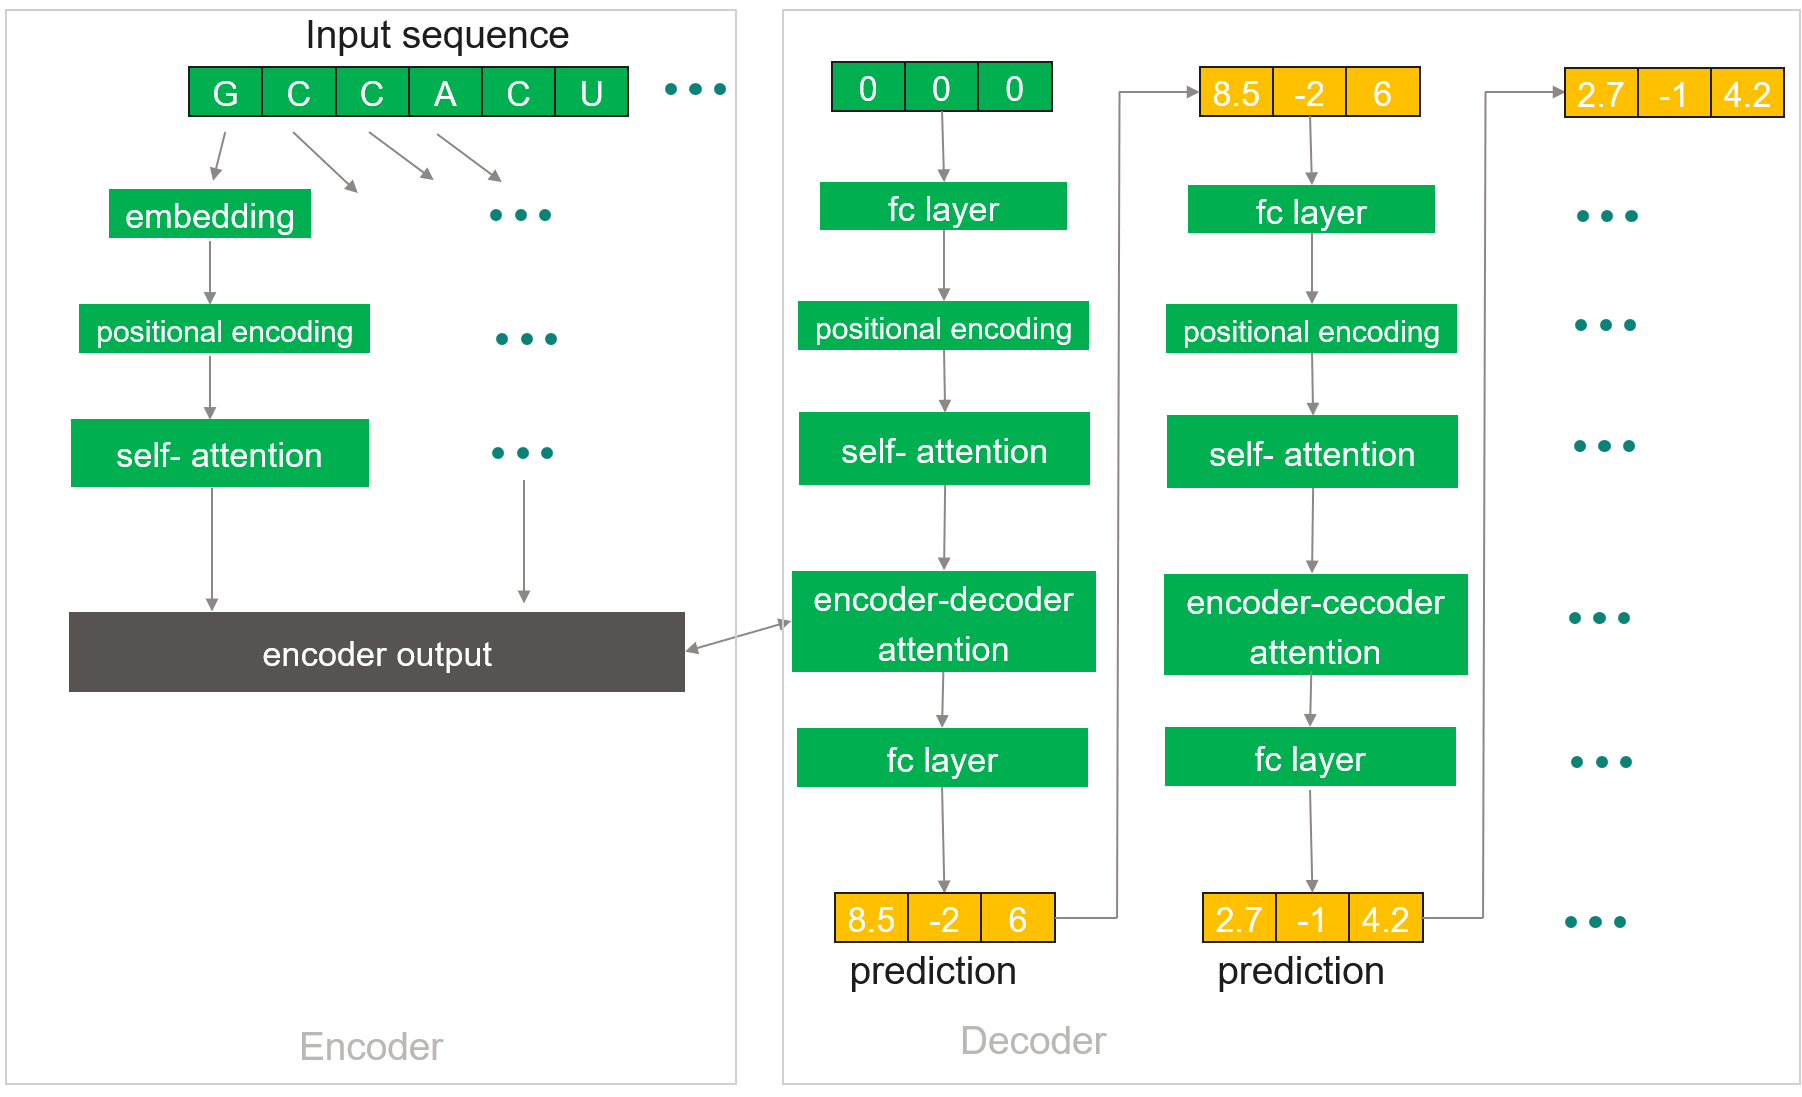

In [144]:
display(Image("images/RNA_transformer_V1.png"))

In [78]:
TRANSFORMER_CONTEXT_LENGTH = 4420

Define the dataset

In [79]:
class RNASequenceDataset(Dataset):
    def __init__(self, inputs: List[Tensor], targets: List[Tensor])  -> None:
        self.inputs = inputs
        self.targets = targets

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        return self.inputs[index], self.targets[index]
    
    def __len__(self) -> int:
        return len(self.inputs)

Define the model

In [80]:
class RNATransformerV1(nn.Module):
    def __init__(self, d_ff, num_attention_layers=1, embedding_features=6, sq_vocab_size=5, 
                 max_sequence_len=4298, num_heads=2, dropout=0.05, verbose=False):
        super(RNATransformerV1, self).__init__()
        self.verbose = verbose
        self.encoder_embedding = nn.Embedding(num_embeddings=sq_vocab_size, embedding_dim=embedding_features)
        self.decoder_initial_ff = nn.Linear(in_features=3, out_features=embedding_features)
        self.positional_encoding = PositionalEncoding(max_sequence_len, embedding_features)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embedding_features, num_heads, d_ff, dropout)
            for _ in range(num_attention_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(embedding_features, num_heads, d_ff, dropout)
            for _ in range(num_attention_layers)
        ])
        self.fc = nn.Linear(embedding_features, 3)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, X: Tensor, y: Tensor):
        with torch.no_grad():
            device = X.device
            X_mask = (X != 0).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, S]
            seq_length = y.size(1)
            y_padding_mask = X_mask 
            y_nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=device), diagonal=1)).bool() # [1, S, S]
            y_nopeak_mask = y_nopeak_mask.unsqueeze(1) # [1, 1, S, S]
            y_mask = y_padding_mask & y_nopeak_mask # [B, 1, S, S]
            return X_mask, y_mask

    def forward(self, X, y):
        X_mask, y_mask = self.generate_mask(X, y)
        embedded_X = self.encoder_embedding(X)
        embedded_X = self.positional_encoding(embedded_X)
        embedded_X = self.dropout(embedded_X)
        embedded_y = self.decoder_initial_ff(y)
        embedded_y = self.positional_encoding(embedded_y)
        embedded_y = self.dropout(embedded_y)
        if self.verbose:
            print(f"embedded y shape: {embedded_y.shape}")
            print(f"embedded x shape : {embedded_X.shape}")
        enc_output = embedded_X
        for i, encoder_layer in enumerate(self.encoder_layers):
            enc_output = encoder_layer(enc_output, X_mask)
        if self.verbose:
            print(f"enc_output shape: {enc_output.shape}")
        dec_output = embedded_y
        for i, decoder_layer in enumerate(self.decoder_layers):
            dec_output = decoder_layer(dec_output, enc_output, X_mask, y_mask)
        if self.verbose:
            print(f"dec_output shape: {dec_output.shape}")
        output = self.fc(dec_output)
        if self.verbose:
            print(f"output shape: {output.shape}")
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_features):
        super(PositionalEncoding, self).__init__()
        padded_embedding_features = embedding_features + (embedding_features % 2)
        positional_encoding = torch.zeros(max_sequence_len, padded_embedding_features)
        position = torch.arange(0, max_sequence_len, dtype=float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, padded_embedding_features, 2).float() * - (math.log(10000.0) / padded_embedding_features))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', positional_encoding.unsqueeze(0))

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1)]


class PoistionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoistionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PoistionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = x + self.dropout(self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask))
        x = x + self.dropout(self.feed_forward(self.norm2(x)))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PoistionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        norm_x = self.norm1(x)
        x = x + self.dropout(self.self_attn(norm_x, norm_x, norm_x, tgt_mask))
        norm_x = self.norm2(x)
        x = x + self.dropout(self.cross_attn(norm_x, enc_output, enc_output, src_mask))
        norm_x = self.norm3(x)
        x = x + self.dropout(self.feed_forward(norm_x))
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Query, Key, Value, mask=None):
        attn_scores = torch.matmul(Query, Key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, Value)
        return output

    def forward(self, Query, Key, Value, mask=None):
        q_full = self.W_q(Query)
        k_full = self.W_k(Key)
        v_full = self.W_v(Value)
        Query = self.split_heads(q_full)
        Key = self.split_heads(k_full)
        Value = self.split_heads(v_full)
        attn_output = self.scaled_dot_product_attention(Query, Key, Value, mask)
        combined = self.combine_heads(attn_output)
        return self.W_o(combined)

    def split_heads(self, x):
        batch_size, seq_length, _ = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)


In [81]:
class Kabsch_loss(nn.Module):    
    
    def __init__(self):
        super(Kabsch_loss, self).__init__()

    def forward(self, predictions : Tensor, targets : Tensor) -> Tensor:
        """
        Computes the optimal rotation and translation to align two sets of points (P -> Q),
        and returnes the RMSD, in a batched manner.
        :param P: A BxNx3 matrix of points
        :param Q: A BxNx3 matrix of points
        :return: The RMSD after optimal alignment.
        """
        assert predictions.shape == targets.shape, "Matrix dimensions must match"

        # Compute centroids
        centroid_P = torch.mean(predictions, dim=1, keepdims=True)  # BxNx3
        centroid_Q = torch.mean(targets, dim=1, keepdims=True)  # BxNx3

        # Center the points
        p = predictions - centroid_P  # BxNx3
        q = targets - centroid_Q  # BxNx3

        # Compute the covariance matrix
        H = torch.matmul(p.transpose(1, 2), q)  # Bx3x3

        # SVD
        U, S, Vt = torch.linalg.svd(H)  # Bx3x3

        # Validate right-handed coordinate system
        d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2)))  # B
        flip = d < 0.0
        if flip.any().item():
            Vt = Vt.clone()
            Vt[flip, -1] *= -1.0

        # Optimal rotation
        R = torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))

        # RMSD
        rmsd = torch.sqrt(torch.sum(torch.square(torch.matmul(p, R.transpose(1, 2)) - q), dim=(1, 2)) / predictions.shape[1])
        return rmsd.mean()

### Pretraining

In [82]:
all_inputs = []
all_targets = []

for i in range(1, 6):
    print(f"Loading pickle file {i}/5...")
    
    with open(f'{PICKLE_DIR}/inputs_{i}.pkl', 'rb') as f:
        inputs = pickle.load(f)
        all_inputs.extend(inputs)
    
    with open(f'{PICKLE_DIR}/targets_{i}.pkl', 'rb') as f:
        targets = pickle.load(f)
        all_targets.extend(targets)
    
    print(f"File {i}: loaded {len(inputs)} sequences")

print(f"Total loaded: {len(all_inputs)} sequences")

inputs = all_inputs
targets = all_targets

Loading pickle file 1/5...
File 1: loaded 50000 sequences
Loading pickle file 2/5...
File 2: loaded 49999 sequences
Loading pickle file 3/5...
File 3: loaded 50000 sequences
Loading pickle file 4/5...
File 4: loaded 49999 sequences
Loading pickle file 5/5...
File 5: loaded 50000 sequences
Total loaded: 249998 sequences


Cut the tensors to the max context length of the transformer

In [83]:
inputs = [tensor[:TRANSFORMER_CONTEXT_LENGTH] for tensor in inputs]
targets = [tensor[:TRANSFORMER_CONTEXT_LENGTH] for tensor in targets]

Pad the tensors that are shorter than the context length of the transformer

In [84]:
inputs = [F.pad(tensor, (0, TRANSFORMER_CONTEXT_LENGTH - len(tensor))) for tensor in inputs]
targets = [F.pad(tensor, (0, 0, 0, TRANSFORMER_CONTEXT_LENGTH - len(tensor))) for tensor in targets]

Test the model forward pass

In [85]:
model = RNATransformerV1(d_ff = 1,num_attention_layers=1,num_heads=2,embedding_features=6, max_sequence_len=10)
tensor1 = torch.randint(1, 5, (1, 10)).to(torch.long).to(torch.int32)
tensor1[:, -5:] = 0  # Set the last 5 entries to 0 to simulate padding
tensor2 = torch.randint(1, 5, (1, 10, 3)).to(torch.long).to(torch.float32)
tensor2[:, -5:, :] = 0 
result = model(tensor1, tensor2)
print(result) # Should be (1, 10, 3)

tensor([[[ 4.0020e-01, -6.0623e-01,  8.1936e-01],
         [ 6.9534e-01, -7.3590e-01,  9.1451e-01],
         [-1.3031e-03,  7.1220e-02,  1.8443e+00],
         [ 2.6391e-01, -1.8471e+00,  9.7429e-01],
         [ 4.5110e-02, -1.1522e+00,  7.3954e-01],
         [-4.3035e-01,  2.2491e-01, -1.2940e-01],
         [ 2.3670e-01,  2.4064e-01,  1.4665e-01],
         [ 6.7169e-01, -7.2293e-02,  2.4083e-01],
         [ 5.7976e-01, -4.6917e-01,  1.1653e-01],
         [ 2.1023e-01, -4.2802e-01, -4.6246e-03]]], grad_fn=<ViewBackward0>)


In [86]:
tensor2

tensor([[[1., 4., 2.],
         [4., 2., 1.],
         [3., 3., 3.],
         [3., 4., 4.],
         [2., 4., 2.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [87]:
tensor1

tensor([[3, 1, 3, 2, 2, 0, 0, 0, 0, 0]], dtype=torch.int32)

Define the training loop

In [88]:
def train_model_with_scheduler(model, train_loader, val_loader, num_epochs, criterion, optimizer, device=None):
    if device:
        model.to(device)
        criterion.to(device)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,  
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")):
            if device:
                X, y = X.to(device), y.to(device)  
            
            optimizer.zero_grad()
            outputs = model(X, y)
            loss = criterion(outputs, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")):
                if device:
                    X, y = X.to(device), y.to(device)
                outputs = model(X, y)
                loss = criterion(outputs, y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

Training parameters

In [89]:
BATCH_SIZE = 6 
EPOCHS = 1
NUM_ATTENTION_LAYERS = 1
NUM_ATTENTION_HEADS = 6
NUM_EMBEDDING_FEATURES = 60
LEARNING_RATE = 1e-3
FEAT_FORWARD_DIM = 1

Create dataloaders

In [90]:
dataset = RNASequenceDataset(inputs, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
max_sequence_len = max(tensor.shape[0] for tensor in inputs)
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
dl_valid = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Create the final model for training

In [91]:
model = RNATransformerV1(d_ff = FEAT_FORWARD_DIM,num_attention_layers=NUM_ATTENTION_LAYERS,num_heads=NUM_ATTENTION_HEADS,
                    embedding_features=NUM_EMBEDDING_FEATURES, max_sequence_len=TRANSFORMER_CONTEXT_LENGTH)
criterion = Kabsch_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [92]:
if V1_PRETRAIN_ENABLED:
    device = torch.device(DEVICE) 
    train_model_with_scheduler(model, dl_train , dl_valid, EPOCHS, criterion, optimizer, device=device)
    torch.save(model.state_dict(), f"{MODEL_DIR}/rna_transformer_v1_pretrained_5.pth")

In [93]:
del inputs
del targets
gc.collect()

0

### Finetune

In [94]:
train_sequences = pd.concat([pd.read_csv(TRAIN_SEQ_PATH), pd.read_csv(TRAIN_SEQ2_PATH)], ignore_index=True)
train_labels = pd.concat([pd.read_csv(TRAIN_LABELS_PATH), pd.read_csv(TRAIN_LABELS2_PATH)],ignore_index=True) 
test_sequences = pd.read_csv(TEST_SEQ_PATH)

Data preprocessing

In [95]:
train_labels.loc[train_labels.resname == '-', 'resname'] = train_labels.loc[train_labels.resname == '-', 'resname'].replace('-', 'G')
train_labels.loc[train_labels.resname == 'X', 'resname'] = train_labels.loc[train_labels.resname == 'X', 'resname'].replace('X', 'G')

pattern = re.compile(r'[^GCAU]')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x)))]
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('X', 'G')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('-', 'G')

train_labels.fillna({ 'x_1': train_labels['x_1'].mean()}, inplace=True)
train_labels.fillna({ 'y_1': train_labels['y_1'].mean()}, inplace=True)
train_labels.fillna({ 'z_1': train_labels['z_1'].mean()}, inplace=True)

In [96]:
train_labels["sequence_id"] = train_labels["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))
train_sequences = train_sequences.drop_duplicates( subset='target_id', keep='first')
train_labels = train_labels.drop_duplicates(subset='ID', keep='first')
train_sequences['seq_length'] = train_sequences['sequence'].apply(lambda x: len(x))
train_labels['seq_length'] = train_labels['sequence_id'].map(train_labels['sequence_id'].value_counts())

Check if labels and sequences are consistent in length

In [97]:
merged_df = pd.merge(train_labels,train_sequences, left_on='sequence_id', right_on='target_id', how='inner')
merged_df['seq_length_diff'] = merged_df['seq_length_x'] != merged_df['seq_length_y']
diff_df = merged_df[merged_df['seq_length_diff']]

print(len(diff_df['sequence_id'].unique()))

0


In [98]:
del merged_df
del diff_df
gc.collect()

36

In [99]:
# the desired uniform length for all sequences
max_length = TRANSFORMER_CONTEXT_LENGTH 

# pad the sequences
padded_sequences_train = train_sequences[["sequence","target_id"]]
padded_sequences_train.loc[:, "sequence"] = padded_sequences_train['sequence'].str.pad(width=max_length, side='right', fillchar='0')

# convert them to dictionaries
padded_sequences_train_dict = {row['target_id']: row['sequence'] for index, row in padded_sequences_train.iterrows()}
print(len(padded_sequences_train_dict))

# pad the labels and convert them to dictionaries
def pad_coordinate_sequence(array, desired_length):
    num_padding = desired_length - len(array)
    padding = np.zeros((num_padding, 3), dtype=int)
    padded_array = np.concatenate((array,padding),axis=0)
    return padded_array

def pad_labels(labels_df, target_length):
    """
    Processes a labels DataFrame by grouping rows by target_id.
    Returns a dictionary mapping target_id to an array of coordinates (seq_len, 3).
    """
    label_dict = {}
    for idx, row in labels_df.iterrows():
        # Split ID into target_id and residue number (assumes format "targetid_resid")
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        # Extract the coordinates; they should be numeric (missing values already set to 0)
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    
    # Sort residues by resid and stack coordinates
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    label_dict_padded = {k: pad_coordinate_sequence(v,target_length) for k, v in label_dict.items()}
    return label_dict_padded

padded_labels_train_dict = pad_labels(train_labels, max_length)
print(len(padded_labels_train_dict))

# encode the sequences with integers

residue_encoding = {'A': 1, 'C': 2, 'G': 3, 'U': 4, '0': 0}
padded_sequences_train_dict = {k: [residue_encoding[res] for res in v] for k, v in padded_sequences_train_dict.items()}

def convert_data_to_tensors(sequence_dict, label_dict):
    sequence_tensors = []
    labels_tensors = []

    for key in label_dict:
        sequence = sequence_dict[key]
        sequence_tensor = torch.tensor(sequence)
        sequence_tensors.append(sequence_tensor)   
        labels_tensor = torch.tensor(label_dict[key], dtype=torch.float32)
        labels_tensors.append(labels_tensor)

    # Stack the tensors
    inputs = torch.stack(sequence_tensors)
    targets = torch.stack(labels_tensors)
    return inputs, targets

inputs_train, targets_train = convert_data_to_tensors(padded_sequences_train_dict, padded_labels_train_dict)
print(f"Input tensor shape (train): {inputs_train.shape}")
print(f"Target tensor shape (train): {targets_train.shape}")


5379
5379
Input tensor shape (train): torch.Size([5379, 4420])
Target tensor shape (train): torch.Size([5379, 4420, 3])


In [100]:
dataset = RNASequenceDataset(inputs_train, targets_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [101]:
EPOCHS = 10
BATCH_SIZE = 2 

In [102]:
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = RNATransformerV1(d_ff = FEAT_FORWARD_DIM,num_attention_layers=NUM_ATTENTION_LAYERS,num_heads=NUM_ATTENTION_HEADS,
                       embedding_features=NUM_EMBEDDING_FEATURES, max_sequence_len=TRANSFORMER_CONTEXT_LENGTH)
model.load_state_dict(torch.load(f"{MODEL_DIR}/rna_transformer_v1_pretrained_5.pth",  map_location=DEVICE))

In [104]:
if V1_FINETUNE_ENABLED:
    device = torch.device(DEVICE) 
    train_model_with_scheduler(model, dl_train , dl_valid, EPOCHS, criterion, optimizer, device=device)
    torch.save(model.state_dict(), f"{MODEL_DIR}/rna_transformer_v1_pretrained_5_finetuned_1.pth")

Trainin loss: TBD 
Validation loss: TBD

In [105]:
del train_sequences
del train_labels
del padded_sequences_train
del padded_labels_train_dict
del padded_sequences_train_dict
del inputs_train
del targets_train
del dl_train
del dl_valid
gc.collect()

10

## RNA Transformer V2
-- Trained on Kaggle GPU P100 --

This model takes the input sequence and applies an embedding and positional encoding as well as self-attention. The resulting features are then fed into a convolutional network which outputs the prediction for each target coordinates.

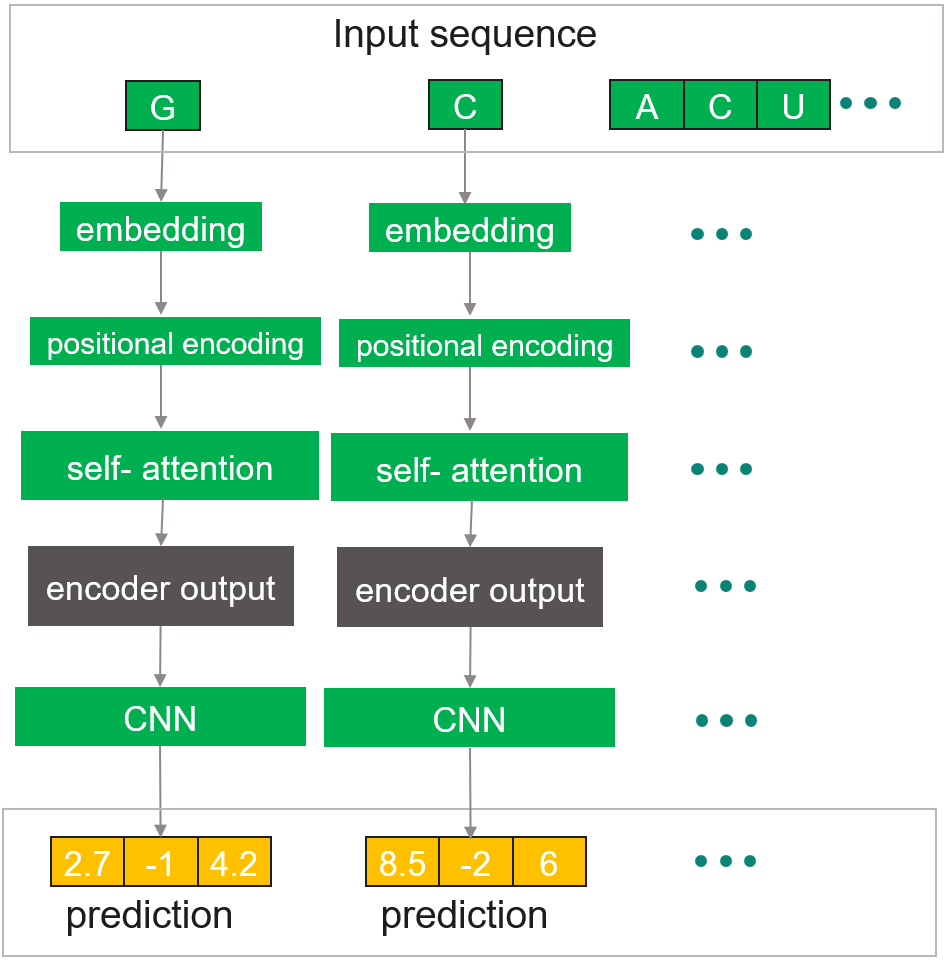

In [145]:
display(Image("images/RNA_transformer_V2.png"))

In [106]:
TRANSFORMER_CONTEXT_LENGTH = 4420

In [107]:
class RNASequenceDataset(Dataset):
    def __init__(self, inputs: List[Tensor], targets: List[Tensor])  -> None:
        self.inputs = inputs
        self.targets = targets

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        return self.inputs[index], self.targets[index]
    
    def __len__(self) -> int:
        return len(self.inputs)

In [108]:
class RNATransformerV2(nn.Module):
    def __init__(self, d_ff, num_attention_layers=1, embedding_features=6,cnn_output_features = 6, sq_vocab_size=5, 
                 max_sequence_len=4298, num_heads=2, dropout=0.05, verbose=False):
        super(RNATransformerV2, self).__init__()
        self.verbose = verbose
        self.encoder_embedding = nn.Embedding(num_embeddings=sq_vocab_size, embedding_dim=embedding_features)
        self.decoder_initial_ff = nn.Linear(in_features=3, out_features=embedding_features)
        self.positional_encoding = PositionalEncoding(max_sequence_len, embedding_features)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embedding_features, num_heads, d_ff, dropout)
            for _ in range(num_attention_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.cnn = ConvolutionalBLock(embedding_features, cnn_output_features)
        self.fc = nn.Linear(cnn_output_features, 3)


    def generate_mask(self, X: Tensor):
        with torch.no_grad():
            X_mask = (X != 0).unsqueeze(1).unsqueeze(2)  # [B, 1, 1, S]
            return X_mask 

    def forward(self, X):
        X_mask = self.generate_mask(X)
        embedded_X = self.encoder_embedding(X)
        embedded_X = self.positional_encoding(embedded_X)
        embedded_X = self.dropout(embedded_X)
        if self.verbose:
            print(f"embedded x shape : {embedded_X.shape}")
        enc_output = embedded_X
        for i, encoder_layer in enumerate(self.encoder_layers):
            enc_output = encoder_layer(enc_output, X_mask)
        conv_output = self.cnn(enc_output) 
        return self.fc(conv_output)


class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_features):
        super(PositionalEncoding, self).__init__()
        padded_embedding_features = embedding_features + (embedding_features % 2)
        positional_encoding = torch.zeros(max_sequence_len, padded_embedding_features)
        position = torch.arange(0, max_sequence_len, dtype=float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, padded_embedding_features, 2).float() * - (math.log(10000.0) / padded_embedding_features))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', positional_encoding.unsqueeze(0))

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1)]


class PoistionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoistionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class ConvolutionalBLock(nn.Module):
    def __init__(self, embedding_features, cnn_output_features):
        super(ConvolutionalBLock, self).__init__()
        self.Conv1 = nn.Conv1d(in_channels=embedding_features, out_channels=cnn_output_features, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(cnn_output_features)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.Conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PoistionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = x + self.dropout(self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask))
        x = x + self.dropout(self.feed_forward(self.norm2(x)))
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Query, Key, Value, mask=None):
        attn_scores = torch.matmul(Query, Key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, Value)
        return output

    def forward(self, Query, Key, Value, mask=None):
        q_full = self.W_q(Query)
        k_full = self.W_k(Key)
        v_full = self.W_v(Value)
        Query = self.split_heads(q_full)
        Key = self.split_heads(k_full)
        Value = self.split_heads(v_full)
        attn_output = self.scaled_dot_product_attention(Query, Key, Value, mask)
        combined = self.combine_heads(attn_output)
        return self.W_o(combined)

    def split_heads(self, x):
        batch_size, seq_length, _ = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)


In [109]:
class Kabsch_loss(nn.Module):    
    
    def __init__(self):
        super(Kabsch_loss, self).__init__()

    def forward(self, predictions : Tensor, targets : Tensor) -> Tensor:
        """
        Computes the optimal rotation and translation to align two sets of points (P -> Q),
        and returnes the RMSD, in a batched manner.
        :param P: A BxNx3 matrix of points
        :param Q: A BxNx3 matrix of points
        :return: The RMSD after optimal alignment.
        """
        assert predictions.shape == targets.shape, "Matrix dimensions must match"

        # Compute centroids
        centroid_P = torch.mean(predictions, dim=1, keepdims=True)  # BxNx3
        centroid_Q = torch.mean(targets, dim=1, keepdims=True)  # BxNx3

        # Center the points
        p = predictions - centroid_P  # BxNx3
        q = targets - centroid_Q  # BxNx3

        # Compute the covariance matrix
        H = torch.matmul(p.transpose(1, 2), q)  # Bx3x3

        # SVD
        U, S, Vt = torch.linalg.svd(H)  # Bx3x3

        # Validate right-handed coordinate system
        d = torch.det(torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2)))  # B
        flip = d < 0.0
        if flip.any().item():
            Vt = Vt.clone()
            Vt[flip, -1] *= -1.0

        # Optimal rotation
        R = torch.matmul(Vt.transpose(1, 2), U.transpose(1, 2))

        # RMSD
        rmsd = torch.sqrt(torch.sum(torch.square(torch.matmul(p, R.transpose(1, 2)) - q), dim=(1, 2)) / predictions.shape[1])
        return rmsd.mean()

Test the model forward pass

In [110]:
model = RNATransformerV2(d_ff = 1,num_attention_layers=1,num_heads=2,embedding_features=6,cnn_output_features=12, max_sequence_len=10)
tensor1 = torch.randint(1, 5, (1, 10)).to(torch.long).to(torch.int32)
tensor1[:, -5:] = 0  # Set the last 5 entries to 0 to simulate padding
result = model(tensor1)
print(result) 

tensor([[[ 0.8272,  0.6460,  0.9740],
         [ 0.0026,  1.2764,  0.3884],
         [ 0.0296, -0.0538, -0.1823],
         [ 0.2381, -0.0013, -0.0837],
         [ 0.3649,  0.2767, -0.0277],
         [ 0.3886,  0.2113,  0.0347],
         [ 0.1938,  0.3224,  0.8600],
         [-0.3638,  0.0830,  0.6342],
         [-0.1025,  0.0590,  0.4324],
         [ 0.2624, -0.4017, -0.8367]]], grad_fn=<AddBackward0>)


In [111]:
result.shape

torch.Size([1, 10, 3])

### Pretraining

In [112]:
all_inputs = []
all_targets = []

for i in range(1, 6):
    print(f"Loading pickle file {i}/5...")
    
    with open(f'{PICKLE_DIR}/inputs_{i}.pkl', 'rb') as f:
        inputs = pickle.load(f)
        all_inputs.extend(inputs)
    
    with open(f'{PICKLE_DIR}/targets_{i}.pkl', 'rb') as f:
        targets = pickle.load(f)
        all_targets.extend(targets)
    
    print(f"File {i}: loaded {len(inputs)} sequences")

print(f"Total loaded: {len(all_inputs)} sequences")

inputs = all_inputs
targets = all_targets

Loading pickle file 1/5...
File 1: loaded 50000 sequences
Loading pickle file 2/5...
File 2: loaded 49999 sequences
Loading pickle file 3/5...
File 3: loaded 50000 sequences
Loading pickle file 4/5...
File 4: loaded 49999 sequences
Loading pickle file 5/5...
File 5: loaded 50000 sequences
Total loaded: 249998 sequences


Cut the tensors to the max context length of the transformer

In [113]:
inputs = [tensor[:TRANSFORMER_CONTEXT_LENGTH] for tensor in inputs]
targets = [tensor[:TRANSFORMER_CONTEXT_LENGTH] for tensor in targets]

Pad the tensors which are shorter than the context length of the transformer

In [114]:
inputs = [F.pad(tensor, (0, TRANSFORMER_CONTEXT_LENGTH - len(tensor))) for tensor in inputs]
targets = [F.pad(tensor, (0, 0, 0, TRANSFORMER_CONTEXT_LENGTH - len(tensor))) for tensor in targets]

Define the training loop

In [115]:
def train_model_with_scheduler(model, train_loader, val_loader, num_epochs, criterion, optimizer, device=None):
    if device:
        model.to(device)
        criterion.to(device)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,  
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")):
            if device:
                X, y = X.to(device), y.to(device)  
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")):
                if device:
                    X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

Training parameters

In [116]:
BATCH_SIZE = 6
EPOCHS = 5
NUM_ATTENTION_LAYERS = 1
NUM_ATTENTION_HEADS = 6
NUM_EMBEDDING_FEATURES = 60
LEARNING_RATE = 1e-3
FEAT_FORWARD_DIM = 1

Create dataloaders

In [117]:
dataset = RNASequenceDataset(inputs, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
max_sequence_len = max(tensor.shape[0] for tensor in inputs)
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
dl_valid = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Create the final model for training

In [118]:
model = RNATransformerV2(d_ff = FEAT_FORWARD_DIM,num_attention_layers=NUM_ATTENTION_LAYERS,num_heads=NUM_ATTENTION_HEADS,
                    embedding_features=NUM_EMBEDDING_FEATURES, max_sequence_len=TRANSFORMER_CONTEXT_LENGTH)
criterion = Kabsch_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [119]:
if V2_PRETRAIN_ENABLED:
    device = torch.device(DEVICE) 
    train_model_with_scheduler(model, dl_train , dl_valid, EPOCHS, criterion, optimizer, device=device)
    torch.save(model.state_dict(), f"{MODEL_DIR}/rna_transformer_v3_pretrained_5.pth")

In [120]:
del inputs
del targets
gc.collect()

20

### Finetune

In [121]:
# Load CSV files
train_sequences = pd.concat([pd.read_csv(TRAIN_SEQ_PATH), pd.read_csv(TRAIN_SEQ2_PATH)], ignore_index=True)
train_labels = pd.concat([pd.read_csv(TRAIN_LABELS_PATH), pd.read_csv(TRAIN_LABELS2_PATH)],ignore_index=True) 
test_sequences = pd.read_csv(TEST_SEQ_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

data preprocessing

In [122]:
train_labels.loc[train_labels.resname == '-', 'resname'] = train_labels.loc[train_labels.resname == '-', 'resname'].replace('-', 'G')
train_labels.loc[train_labels.resname == 'X', 'resname'] = train_labels.loc[train_labels.resname == 'X', 'resname'].replace('X', 'G')

pattern = re.compile(r'[^GCAU]')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x)))]
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('X', 'G')
train_sequences.loc[train_sequences['sequence'].apply(lambda x: bool(pattern.search(x))), 'sequence'] = train_sequences['sequence'].str.replace('-', 'G')

train_labels.fillna({ 'x_1': train_labels['x_1'].mean()}, inplace=True)
train_labels.fillna({ 'y_1': train_labels['y_1'].mean()}, inplace=True)
train_labels.fillna({ 'z_1': train_labels['z_1'].mean()}, inplace=True)

In [123]:
train_labels["sequence_id"] = train_labels["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))
train_sequences = train_sequences.drop_duplicates( subset='target_id', keep='first')
train_labels = train_labels.drop_duplicates(subset='ID', keep='first')
train_sequences['seq_length'] = train_sequences['sequence'].apply(lambda x: len(x))
train_labels['seq_length'] = train_labels['sequence_id'].map(train_labels['sequence_id'].value_counts())

check if labels and sequences are consistent in length

In [124]:
merged_df = pd.merge(train_labels,train_sequences, left_on='sequence_id', right_on='target_id', how='inner')
merged_df['seq_length_diff'] = merged_df['seq_length_x'] != merged_df['seq_length_y']
diff_df = merged_df[merged_df['seq_length_diff']]

print(len(diff_df['sequence_id'].unique()))

0


In [125]:
del merged_df
del diff_df
gc.collect()

36

In [126]:
# the desired uniform length for all sequences
max_length = TRANSFORMER_CONTEXT_LENGTH 

# pad the sequences
padded_sequences_train = train_sequences[["sequence","target_id"]]
padded_sequences_train.loc[:, "sequence"] = padded_sequences_train['sequence'].str.pad(width=max_length, side='right', fillchar='0')

# convert them to dictionaries
padded_sequences_train_dict = {row['target_id']: row['sequence'] for index, row in padded_sequences_train.iterrows()}
print(len(padded_sequences_train_dict))

# pad the labels and convert them to dictionaries
def pad_coordinate_sequence(array, desired_length):
    num_padding = desired_length - len(array)
    padding = np.zeros((num_padding, 3), dtype=int)
    padded_array = np.concatenate((array,padding),axis=0)
    return padded_array

def pad_labels(labels_df, target_length):
    """
    Processes a labels DataFrame by grouping rows by target_id.
    Returns a dictionary mapping target_id to an array of coordinates (seq_len, 3).
    """
    label_dict = {}
    for idx, row in labels_df.iterrows():
        # Split ID into target_id and residue number (assumes format "targetid_resid")
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        # Extract the coordinates; they should be numeric (missing values already set to 0)
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    
    # Sort residues by resid and stack coordinates
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    label_dict_padded = {k: pad_coordinate_sequence(v,target_length) for k, v in label_dict.items()}
    return label_dict_padded

padded_labels_train_dict = pad_labels(train_labels, max_length)
print(len(padded_labels_train_dict))

# encode the sequences with integers

residue_encoding = {'A': 1, 'C': 2, 'G': 3, 'U': 4, '0': 0}
padded_sequences_train_dict = {k: [residue_encoding[res] for res in v] for k, v in padded_sequences_train_dict.items()}

def convert_data_to_tensors(sequence_dict, label_dict):
    sequence_tensors = []
    labels_tensors = []

    for key in label_dict:
        sequence = sequence_dict[key]
        sequence_tensor = torch.tensor(sequence)
        sequence_tensors.append(sequence_tensor)   
        labels_tensor = torch.tensor(label_dict[key], dtype=torch.float32)
        labels_tensors.append(labels_tensor)

    # Stack the tensors
    inputs = torch.stack(sequence_tensors)
    targets = torch.stack(labels_tensors)
    return inputs, targets

inputs_train, targets_train = convert_data_to_tensors(padded_sequences_train_dict, padded_labels_train_dict)
print(f"Input tensor shape (train): {inputs_train.shape}")
print(f"Target tensor shape (train): {targets_train.shape}")


5379
5379
Input tensor shape (train): torch.Size([5379, 4420])
Target tensor shape (train): torch.Size([5379, 4420, 3])


In [127]:
dataset = RNASequenceDataset(inputs_train, targets_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [128]:
EPOCHS = 10
BATCH_SIZE = 2 

In [129]:
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = RNATransformerV2(d_ff = FEAT_FORWARD_DIM,num_attention_layers=NUM_ATTENTION_LAYERS,num_heads=NUM_ATTENTION_HEADS,
                       embedding_features=NUM_EMBEDDING_FEATURES, max_sequence_len=TRANSFORMER_CONTEXT_LENGTH)
model.load_state_dict(torch.load(f"{MODEL_DIR}/rna_transformer_v3_pretrained_1.pth",  map_location=DEVICE))

In [131]:
if V2_FINETUNE_ENABLED:
    device = torch.device(DEVICE) 
    train_model_with_scheduler(model, dl_train , dl_valid, EPOCHS, criterion, optimizer, device=device)
    torch.save(model.state_dict(), f"{MODEL_DIR}/rna_transformer_v3_pretrained_5_finetuned_1.pth")

In [132]:
del train_sequences
del train_labels
del padded_sequences_train
del padded_labels_train_dict
del padded_sequences_train_dict
del inputs_train
del targets_train
del dl_train
del dl_valid
gc.collect()

10

## Conclusion

(Un-) expected challenges of this approach:

- <b>Resource intensity</b> : 
    In the process of model training, GPU memory became a clear bottleneck because of the relatively high context length of our models. The "out of memory" errors were frequent. 
    Decreasing the batch_size and moving from the own hardware to more powerful resources (Kaggle) has helped a lot here.
- <b>Data intensity</b>: 
    Since the real life training data was quite limited, we opted for pre-training the models on synthetic data. A challenge here was the preprocessing of the data from protein database files to tensors. The preprocessing was compute and memory intensive. A very helpful tool here was to cache data into pickle files at various points of the preprocessing in order to free up memory.

Judging by the score on the Kaggle private and public test set, the transformer V1 model does not significantly improve the accuracy in comparison to the simple baseline model, while V2 performs even worse. 
Nevertheless, the Kaggle leaderboard was never the main objective. The goal was to gain more in-depth hands-on experience with transformer-based models, which has been a great success. 
Thank you very much for reading, and I am looking forward to participating in many more machine learning competitions.